In [ ]:
import os
import re
import pickle
import shutil
from functions import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set consistent color scheme
sns.set_palette("husl")
NODE_COLOR = '#6baed6'  # Soft blue
EDGE_CMAP = plt.cm.viridis  # Colormap for weighted edges
NODE_CMAP = plt.cm.YlOrRd  # Colormap for node metrics

# Working with the character networks

In [ ]:
path = 'graphs'
unweighted = 'dg_characters.pickle'
weighted = 'dgw_characters.pickle'

In [ ]:
# Load the graphs
def load_graphs(graph: str, path: str = 'graphs'):
    with open(os.path.join(path,graph), 'rb') as f:
        loaded_graph = pickle.load(f)
    
    return loaded_graph

In [ ]:
dg_char = load_graphs(unweighted)
print(f"\nUnweighted character network complete!")
print(f"  Nodes: {dg_char.number_of_nodes()}")
print(f"  Edges: {dg_char.number_of_edges()}")
dgw_char = load_graphs(weighted)
print(f"\nUnweighted character network complete!")
print(f"  Nodes: {dgw_char.number_of_nodes()}")
print(f"  Edges: {dgw_char.number_of_edges()}")

## Looking at the nodes with highest in degrees

In [ ]:
# Analyze most connected characters
char_degrees = dict(dg_char.degree())
top_chars = sorted(char_degrees.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 most connected characters (by degree):")
for i, (char, degree) in enumerate(top_chars, 1):
    print(f"{i}. {char}: {degree}")

In [ ]:
# Get largest connected component and calculate centrality measures

largest_cc_unweighted = max(nx.weakly_connected_components(dg_char), key=len)
dg_char_main = dg_char.subgraph(largest_cc_unweighted).copy()

print(f"Largest weakly connected component: {dg_char_main.number_of_nodes()} nodes, {dg_char_main.number_of_edges()} edges")

# Calculate centrality measures
print("\nCalculating centrality measures...")
char_betweenness = nx.betweenness_centrality(dg_char_main)
char_closeness = nx.closeness_centrality(dg_char_main)
char_eigenvector = nx.eigenvector_centrality(dg_char_main, max_iter=1000)

print("\nTop 10 characters by betweenness centrality:")
for i, (char, bc) in enumerate(sorted(char_betweenness.items(), key=lambda x: x[1], reverse=True)[:10], 1):
    print(f"{i}. {char}: {bc:.6f}")

## Visualizing the graphs

In [ ]:
# Visualize the character network
# Calculate layout
pos_unweighted = nx.forceatlas2_layout(dg_char_main)

# Node sizes by degree
degrees = dict(dg_char_main.degree())
node_sizes = [degrees[n] * 20 for n in dg_char_main.nodes()]

In [ ]:
print(f"Visualizing character network: {dg_char_main.number_of_nodes()} nodes, {dg_char_main.number_of_edges()} edges")
# Draw
fig, ax = plt.subplots(figsize=(15, 12))

nx.draw_networkx_edges(dg_char_main, pos_unweighted, alpha=0.3, ax=ax)
nx.draw_networkx_nodes(dg_char_main, pos_unweighted, node_size=node_sizes, 
                       node_color=NODE_COLOR, alpha=0.8, ax=ax)

# Label top nodes only
top_n = 30
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
labels = {node: node for node, _ in top_nodes}
nx.draw_networkx_labels(dg_char_main, pos_unweighted, labels, font_size=8, ax=ax)

ax.set_title(f'Character Network (direct links between character pages)', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze the weighted network
# Show top edges by weight

edge_weights = [(u, v, data['weight']) for u, v, data in dgw_char.edges(data=True)]
edge_weights_sorted = sorted(edge_weights, key=lambda x: x[2], reverse=True)

print("Top 20 character connections by mention count:")
for i, (source, target, weight) in enumerate(edge_weights_sorted[:20], 1):
    print(f"{i}. {source} → {target}: {weight} mentions")

# Show statistics
weights = [w for _, _, w in edge_weights]
print(f"\nWeight statistics:")
print(f"  Mean weight: {sum(weights) / len(weights):.2f}")
print(f"  Max weight: {max(weights)}")
print(f"  Min weight: {min(weights)}")
print(f"  Total mentions tracked: {sum(weights)}")

In [ ]:
# Visualize the weighted character network

# Get largest connected component for visualization

largest_cc_weighted = max(nx.weakly_connected_components(dgw_char), key=len)
DGW_main = dgw_char.subgraph(largest_cc_weighted).copy()

# Calculate layout
pos_weighted = nx.forceatlas2_layout(DGW_main)

In [ ]:
print(f"Visualizing weighted character network: {DGW_main.number_of_nodes()} nodes, {DGW_main.number_of_edges()} edges")
# Get edge weights for visualization
edges = DGW_main.edges()
weights = [DGW_main[u][v]['weight'] for u, v in edges]

# Normalize weights for visualization (edge width)
max_weight = max(weights)
min_weight = min(weights)
# Scale edge widths between 0.5 and 5
edge_widths = [0.5 + 4.5 * (w - min_weight) / (max_weight - min_weight) if max_weight > min_weight else 2 for w in weights]

# Normalize weights for color mapping
edge_colors = weights

# Node sizes by degree
degrees = dict(DGW_main.degree())
node_sizes = [degrees[n] * 20 for n in DGW_main.nodes()]

# Draw
fig, ax = plt.subplots(figsize=(18, 14))

# Draw edges with varying widths and colors based on weight
edges_collection = nx.draw_networkx_edges(
    DGW_main, pos_weighted, 
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=EDGE_CMAP,
    edge_vmin=min_weight,
    edge_vmax=max_weight,
    alpha=0.7,
    arrows=True,
    arrowsize=10,
    ax=ax
)

# Draw nodes
nx.draw_networkx_nodes(DGW_main, pos_weighted, node_size=node_sizes, 
                        node_color=NODE_COLOR, alpha=0.8, ax=ax)

# Label top nodes only
top_n = 30
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
labels = {node: node for node, _ in top_nodes}
nx.draw_networkx_labels(DGW_main, pos_weighted, labels, font_size=8, ax=ax)

# Add colorbar for edge weights
sm = plt.cm.ScalarMappable(cmap=EDGE_CMAP, 
                            norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Mention Count', shrink=0.8)

ax.set_title('Weighted Character Network\n(Edge thickness and color indicate mention count)', 
                fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"\nWeight statistics:")
print(f"  Min weight: {min_weight}")
print(f"  Max weight: {max_weight}")
print(f"  Mean weight: {np.mean(weights):.2f}")
print(f"  Median weight: {np.median(weights):.2f}")

In [ ]:
# Visualize weighted character network with node sizes by weighted in-degree
# Use the same connected component
largest_cc_weighted_indegree = max(nx.weakly_connected_components(dgw_char), key=len)
DGW_main_indegree = dgw_char.subgraph(largest_cc_weighted_indegree).copy()

# Calculate layout (same as previous for consistency)
pos_weighted_indegree = nx.forceatlas2_layout(DGW_main_indegree)

In [ ]:
print(f"Visualizing weighted character network by in-degree: {DGW_main_indegree.number_of_nodes()} nodes, {DGW_main_indegree.number_of_edges()} edges")

# Calculate weighted in-degree (sum of weights of incoming edges)
weighted_in_degree = {}
for node in DGW_main_indegree.nodes():
    in_edges = DGW_main_indegree.in_edges(node, data=True)
    total_weight = sum(data['weight'] for _, _, data in in_edges)
    weighted_in_degree[node] = total_weight

# Get edge weights for visualization
edges = DGW_main_indegree.edges()
weights = [DGW_main_indegree[u][v]['weight'] for u, v in edges]

# Normalize weights for visualization (edge width)
max_weight = max(weights)
min_weight = min(weights)
edge_widths = [0.5 + 4.5 * (w - min_weight) / (max_weight - min_weight) if max_weight > min_weight else 2 for w in weights]
edge_colors = weights

# Node sizes by weighted in-degree
max_in_degree = max(weighted_in_degree.values()) if weighted_in_degree else 1
min_in_degree = min(weighted_in_degree.values()) if weighted_in_degree else 0
node_sizes = [50 + 950 * (weighted_in_degree[n] - min_in_degree) / (max_in_degree - min_in_degree) 
              if max_in_degree > min_in_degree else 500 
              for n in DGW_main_indegree.nodes()]

# Node colors by weighted in-degree
node_colors = [weighted_in_degree[n] for n in DGW_main_indegree.nodes()]

# Draw
fig, ax = plt.subplots(figsize=(18, 14))

# Draw edges
nx.draw_networkx_edges(
    DGW_main_indegree, pos_weighted_indegree, 
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=EDGE_CMAP,
    edge_vmin=min_weight,
    edge_vmax=max_weight,
    alpha=0.5,
    arrows=True,
    arrowsize=10,
    ax=ax
)

# Draw nodes with color and size based on weighted in-degree
nodes_collection = nx.draw_networkx_nodes(
    DGW_main_indegree, pos_weighted_indegree, 
    node_size=node_sizes,
    node_color=node_colors,
    cmap=NODE_CMAP,
    vmin=min_in_degree,
    vmax=max_in_degree,
    alpha=0.8,
    ax=ax
)

# Label top nodes by weighted in-degree
top_n = 30
top_nodes_by_in_degree = sorted(weighted_in_degree.items(), key=lambda x: x[1], reverse=True)[:top_n]
labels = {node: node for node, _ in top_nodes_by_in_degree}
nx.draw_networkx_labels(DGW_main_indegree, pos_weighted_indegree, labels, font_size=8, ax=ax)

# Add colorbar for node colors (weighted in-degree)
sm_nodes = plt.cm.ScalarMappable(cmap=NODE_CMAP, 
                                 norm=plt.Normalize(vmin=min_in_degree, vmax=max_in_degree))
sm_nodes.set_array([])
cbar_nodes = plt.colorbar(sm_nodes, ax=ax, label='Weighted In-Degree\n(Total Mentions Received)', 
                          shrink=0.8, pad=0.02)

ax.set_title('Weighted Character Network\n(Node size and color by weighted in-degree = total mentions received)', 
             fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
print(f"\nWeighted In-Degree statistics:")
print(f"  Min: {min_in_degree}")
print(f"  Max: {max_in_degree}")
print(f"  Mean: {np.mean(list(weighted_in_degree.values())):.2f}")
print(f"  Median: {np.median(list(weighted_in_degree.values())):.2f}")

print(f"\nTop 10 characters by weighted in-degree (most mentioned):")
for i, (char, weight) in enumerate(top_nodes_by_in_degree[:20], 1):
    print(f"  {i}. {char}: {weight} total mentions received")




## Looking at communities

In [ ]:
dg_undir = dg_char.to_undirected()
dgw_undir = dgw_char.to_undirected()

In [ ]:
dg_communities = nx.community.louvain_communities(dg_undir, weight='weight', seed=42)
dgw_communities = nx.community.louvain_communities(dgw_undir, weight='weight', seed=42)

In [ ]:
# Analyze community structure
print(f"=== Community Analysis ===\n")

print(f"Unweighted graph communities: {len(dg_communities)}")
print(f"Weighted graph communities: {len(dgw_communities)}")

# Calculate modularity (quality metric: -0.5 to 1, higher is better)
dg_modularity = nx.community.modularity(dg_undir, dg_communities)
dgw_modularity = nx.community.modularity(dgw_undir, dgw_communities, weight='weight')

print(f"\nModularity scores:")
print(f"  Unweighted: {dg_modularity:.4f}")
print(f"  Weighted: {dgw_modularity:.4f}")

# Analyze community sizes
print(f"\n=== Community Sizes (Weighted) ===")
sorted_communities = sorted(dgw_communities, key=len, reverse=True)
for i, comm in enumerate(sorted_communities[:10], 1):
    print(f"Community {i}: {len(comm)} members")

# Show members of largest communities
print(f"\n=== Largest Community Members ===")
for i, comm in enumerate(sorted_communities[:3], 1):
    members = sorted(list(comm))[:20]  # Show first 20
    print(f"\nCommunity {i} (showing up to 20/{len(comm)} members):")
    print(f"  {', '.join(members)}")

# Find which community major characters belong to
major_chars = ['Jon Snow', 'Daenerys Targaryen', 'Tyrion Lannister', 
               'Arya Stark', 'Cersei Lannister', 'Sansa Stark']

print(f"\n=== Major Characters by Community ===")
for char in major_chars:
    for i, comm in enumerate(dgw_communities, 1):
        if char in comm:
            print(f"{char}: Community {i} (size: {len(comm)})")
            break

In [ ]:
# Visualize communities - UNWEIGHTED network
print(f"Visualizing communities in unweighted network...")

# Use the main connected component for visualization
G_vis_unw = dg_undir.subgraph(dg_char_main.nodes()).copy()

# Find communities in this subgraph
comm_vis_unw = [comm & set(G_vis_unw.nodes()) for comm in dg_communities if comm & set(G_vis_unw.nodes())]
comm_vis_unw = [c for c in comm_vis_unw if len(c) > 0]

# Assign colors to nodes based on community
node_to_comm_vis_unw = {}
for i, comm in enumerate(comm_vis_unw):
    for node in comm:
        node_to_comm_vis_unw[node] = i

# Create color palette for communities
num_communities_unw = len(comm_vis_unw)
colors_unw = plt.cm.tab20(np.linspace(0, 1, num_communities_unw))

node_colors_comm_unw = [colors_unw[node_to_comm_vis_unw.get(n, 0)] for n in G_vis_unw.nodes()]

# Draw
fig, ax = plt.subplots(figsize=(18, 14))

nx.draw_networkx_edges(G_vis_unw, pos_unweighted, alpha=0.2, ax=ax)
nx.draw_networkx_nodes(G_vis_unw, pos_unweighted, 
                       node_color=node_colors_comm_unw, 
                       node_size=300, 
                       alpha=0.8, ax=ax)

# Label top nodes
degrees_vis_unw = dict(G_vis_unw.degree())
top_nodes_vis_unw = sorted(degrees_vis_unw.items(), key=lambda x: x[1], reverse=True)[:30]
labels_vis_unw = {node: node for node, _ in top_nodes_vis_unw}
nx.draw_networkx_labels(G_vis_unw, pos_unweighted, labels_vis_unw, font_size=8, ax=ax)

ax.set_title(f'Character Communities - Unweighted Network (Louvain)\n{len(comm_vis_unw)} communities detected', 
             fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"\nCommunities in unweighted visualization: {len(comm_vis_unw)}")

In [ ]:
# Visualize communities - WEIGHTED network
print(f"Visualizing communities in weighted network...")

# Use the main connected component for visualization
G_vis = dgw_undir.subgraph(DGW_main.nodes()).copy()

# Find communities in this subgraph
comm_vis = [comm & set(G_vis.nodes()) for comm in dgw_communities if comm & set(G_vis.nodes())]
comm_vis = [c for c in comm_vis if len(c) > 0]

# Assign colors to nodes based on community
node_to_comm_vis = {}
for i, comm in enumerate(comm_vis):
    for node in comm:
        node_to_comm_vis[node] = i

# Create color palette for communities
num_communities = len(comm_vis)
colors = plt.cm.tab20(np.linspace(0, 1, num_communities))

node_colors_comm = [colors[node_to_comm_vis.get(n, 0)] for n in G_vis.nodes()]

# Draw
fig, ax = plt.subplots(figsize=(18, 14))

nx.draw_networkx_edges(G_vis, pos_weighted, alpha=0.2, ax=ax)
nx.draw_networkx_nodes(G_vis, pos_weighted, 
                       node_color=node_colors_comm, 
                       node_size=300, 
                       alpha=0.8, ax=ax)

# Label top nodes
degrees_vis = dict(G_vis.degree())
top_nodes_vis = sorted(degrees_vis.items(), key=lambda x: x[1], reverse=True)[:30]
labels_vis = {node: node for node, _ in top_nodes_vis}
nx.draw_networkx_labels(G_vis, pos_weighted, labels_vis, font_size=8, ax=ax)

ax.set_title(f'Character Communities - Weighted Network (Louvain)\n{len(comm_vis)} communities detected', 
             fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"\nCommunities in weighted visualization: {len(comm_vis)}")

In [ ]:
# Visualize individual communities as subplots - WEIGHTED network
print(f"Creating subplots for largest communities (weighted)...")

# Sort communities by size
sorted_comms = sorted(comm_vis, key=len, reverse=True)

# Show top 6 largest communities
num_to_show = min(6, len(sorted_comms))
fig, axes = plt.subplots(2, 3, figsize=(20, 13))
axes = axes.flatten()

for idx in range(num_to_show):
    comm = sorted_comms[idx]
    ax = axes[idx]
    
    # Create subgraph for this community
    comm_graph = G_vis.subgraph(comm).copy()
    
    # Calculate layout for this community
    comm_pos = nx.spring_layout(comm_graph, k=0.5, iterations=50, seed=42)
    
    # Draw
    nx.draw_networkx_edges(comm_graph, comm_pos, alpha=0.3, ax=ax)
    nx.draw_networkx_nodes(comm_graph, comm_pos, 
                           node_color=colors[idx], 
                           node_size=200, 
                           alpha=0.8, ax=ax)
    
    # Label all nodes if small enough, otherwise top nodes
    if len(comm) <= 15:
        nx.draw_networkx_labels(comm_graph, comm_pos, font_size=7, ax=ax)
    else:
        # Show top 10 by degree
        comm_degrees = dict(comm_graph.degree())
        top_in_comm = sorted(comm_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
        labels_comm = {node: node for node, _ in top_in_comm}
        nx.draw_networkx_labels(comm_graph, comm_pos, labels_comm, font_size=7, ax=ax)
    
    ax.set_title(f'Community {idx+1}: {len(comm)} characters', fontsize=12, fontweight='bold')
    ax.axis('off')

# Hide empty subplots if we have fewer than 6 communities
for idx in range(num_to_show, 6):
    axes[idx].axis('off')

plt.suptitle('Top 6 Communities - Weighted Network', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
# Visualize individual communities as subplots - UNWEIGHTED network
print(f"Creating subplots for largest communities (unweighted)...")

# Sort communities by size
sorted_comms_unw = sorted(comm_vis_unw, key=len, reverse=True)

# Show top 6 largest communities
num_to_show_unw = min(6, len(sorted_comms_unw))
fig, axes = plt.subplots(2, 3, figsize=(20, 13))
axes = axes.flatten()

for idx in range(num_to_show_unw):
    comm = sorted_comms_unw[idx]
    ax = axes[idx]
    
    # Create subgraph for this community
    comm_graph = G_vis_unw.subgraph(comm).copy()
    
    # Calculate layout for this community
    comm_pos = nx.spring_layout(comm_graph, k=0.5, iterations=50, seed=42)
    
    # Draw
    nx.draw_networkx_edges(comm_graph, comm_pos, alpha=0.3, ax=ax)
    nx.draw_networkx_nodes(comm_graph, comm_pos, 
                           node_color=colors_unw[idx], 
                           node_size=200, 
                           alpha=0.8, ax=ax)
    
    # Label all nodes if small enough, otherwise top nodes
    if len(comm) <= 15:
        nx.draw_networkx_labels(comm_graph, comm_pos, font_size=7, ax=ax)
    else:
        # Show top 10 by degree
        comm_degrees = dict(comm_graph.degree())
        top_in_comm = sorted(comm_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
        labels_comm = {node: node for node, _ in top_in_comm}
        nx.draw_networkx_labels(comm_graph, comm_pos, labels_comm, font_size=7, ax=ax)
    
    ax.set_title(f'Community {idx+1}: {len(comm)} characters', fontsize=12, fontweight='bold')
    ax.axis('off')

# Hide empty subplots if we have fewer than 6 communities
for idx in range(num_to_show_unw, 6):
    axes[idx].axis('off')

plt.suptitle('Top 6 Communities - Unweighted Network', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate inter-community vs intra-community edges
print(f"\n=== Edge Distribution ===")

# Count edges within communities vs between communities
intra_edges = 0
inter_edges = 0

# Create node-to-community mapping
node_to_comm = {}
for i, comm in enumerate(dgw_communities):
    for node in comm:
        node_to_comm[node] = i

for u, v in dgw_undir.edges():
    if node_to_comm.get(u) == node_to_comm.get(v):
        intra_edges += 1
    else:
        inter_edges += 1

total_edges = intra_edges + inter_edges
print(f"Edges within communities: {intra_edges} ({100*intra_edges/total_edges:.1f}%)")
print(f"Edges between communities: {inter_edges} ({100*inter_edges/total_edges:.1f}%)")

In [ ]:
# Find overlapping communities using k-clique percolation
# k=4 means communities are formed by overlapping cliques of size 4

print("Finding overlapping communities with k-clique percolation...")
print("This may take a moment...\n")

# Try different k values for unweighted graph
k_values = [3, 4, 5]

dg_kclique_results = {}
for k in k_values:
    try:
        communities = list(nx.community.k_clique_communities(dg_undir, k))
        dg_kclique_results[k] = communities
        print(f"k={k}: Found {len(communities)} overlapping communities")
    except Exception as e:
        print(f"k={k}: Could not compute (graph may not have enough cliques of this size)")

# Try for weighted graph
dgw_kclique_results = {}
for k in k_values:
    try:
        communities = list(nx.community.k_clique_communities(dgw_undir, k))
        dgw_kclique_results[k] = communities
        print(f"Weighted k={k}: Found {len(communities)} overlapping communities")
    except Exception as e:
        print(f"Weighted k={k}: Could not compute (graph may not have enough cliques of this size)")

In [93]:
len(dgw_kclique_results[5])

18

In [94]:
# Compare Louvain vs k-clique communities for both weighted and unweighted
print("=== Comparison: Louvain vs k-clique ===\n")

# Weighted graph comparison
print("=" * 60)
print("--- WEIGHTED GRAPH ---")
print("=" * 60)
print(f"\nLouvain (non-overlapping):")
print(f"  Communities: {len(dgw_communities)}")
print(f"  Modularity: {dgw_modularity:.4f}")
print(f"  All nodes assigned: Yes")
print(f"  Total nodes: {dgw_undir.number_of_nodes()}")

# Compare all k-clique versions for weighted graph
print(f"\n{'k-clique (overlapping)':^60}")
print("-" * 60)
for k in [3, 4, 5]:
    if k in dgw_kclique_results and len(dgw_kclique_results[k]) > 0:
        kclique_comms = dgw_kclique_results[k]
        
        print(f"\nk = {k}:")
        print(f"  Communities: {len(kclique_comms)}")
        
        # Count total unique nodes
        all_nodes = set()
        for comm in kclique_comms:
            all_nodes.update(comm)
        
        print(f"  Nodes in communities: {len(all_nodes)}/{dgw_undir.number_of_nodes()} ({100*len(all_nodes)/dgw_undir.number_of_nodes():.1f}%)")
        
        # Count overlapping memberships
        node_count = {}
        for comm in kclique_comms:
            for node in comm:
                node_count[node] = node_count.get(node, 0) + 1
        
        multi_members = sum(1 for count in node_count.values() if count > 1)
        print(f"  Nodes in multiple communities: {multi_members} ({100*multi_members/len(all_nodes):.1f}% of covered nodes)")
        
        avg_memberships = sum(node_count.values()) / len(node_count) if node_count else 0
        print(f"  Average memberships per node: {avg_memberships:.2f}")
        
        # Average community size
        avg_size = sum(len(comm) for comm in kclique_comms) / len(kclique_comms) if kclique_comms else 0
        print(f"  Average community size: {avg_size:.1f}")
    else:
        print(f"\nk = {k}: No communities found")

# Unweighted graph comparison
print("\n\n" + "=" * 60)
print("--- UNWEIGHTED GRAPH ---")
print("=" * 60)
print(f"\nLouvain (non-overlapping):")
print(f"  Communities: {len(dg_communities)}")
print(f"  Modularity: {dg_modularity:.4f}")
print(f"  All nodes assigned: Yes")
print(f"  Total nodes: {dg_undir.number_of_nodes()}")

# Compare all k-clique versions for unweighted graph
print(f"\n{'k-clique (overlapping)':^60}")
print("-" * 60)
for k in [3, 4, 5]:
    if k in dg_kclique_results and len(dg_kclique_results[k]) > 0:
        kclique_comms = dg_kclique_results[k]
        
        print(f"\nk = {k}:")
        print(f"  Communities: {len(kclique_comms)}")
        
        # Count total unique nodes
        all_nodes = set()
        for comm in kclique_comms:
            all_nodes.update(comm)
        
        print(f"  Nodes in communities: {len(all_nodes)}/{dg_undir.number_of_nodes()} ({100*len(all_nodes)/dg_undir.number_of_nodes():.1f}%)")
        
        # Count overlapping memberships
        node_count = {}
        for comm in kclique_comms:
            for node in comm:
                node_count[node] = node_count.get(node, 0) + 1
        
        multi_members = sum(1 for count in node_count.values() if count > 1)
        print(f"  Nodes in multiple communities: {multi_members} ({100*multi_members/len(all_nodes):.1f}% of covered nodes)")
        
        avg_memberships = sum(node_count.values()) / len(node_count) if node_count else 0
        print(f"  Average memberships per node: {avg_memberships:.2f}")
        
        # Average community size
        avg_size = sum(len(comm) for comm in kclique_comms) / len(kclique_comms) if kclique_comms else 0
        print(f"  Average community size: {avg_size:.1f}")
    else:
        print(f"\nk = {k}: No communities found")

print("\n" + "=" * 60)
print("KEY INSIGHTS:")
print("=" * 60)
print("• Louvain: Every node assigned to exactly one community (non-overlapping)")
print("• k-clique: Nodes can belong to multiple communities (overlapping)")
print("• Larger k: More restrictive → fewer, smaller, more cohesive communities")
print("• Smaller k: More permissive → more, larger communities with more overlap")
print("• k-clique captures characters with complex multi-group relationships")

=== Comparison: Louvain vs k-clique ===

--- WEIGHTED GRAPH ---

Louvain (non-overlapping):
  Communities: 34
  Modularity: 0.5527
  All nodes assigned: Yes

k-clique (overlapping, k=4):
  Communities: 16
  Nodes in communities: 737/847
  Nodes in multiple communities: 25
  Average memberships per node: 1.04


--- UNWEIGHTED GRAPH ---

Louvain (non-overlapping):
  Communities: 22
  Modularity: 0.5294
  All nodes assigned: Yes

k-clique (overlapping, k=4):
  Communities: 16
  Nodes in communities: 737/847
  Nodes in multiple communities: 25
  Average memberships per node: 1.04


Key difference: k-clique allows nodes to belong to multiple communities,
better representing characters with complex relationships across different groups.


In [ ]:
# Visualize overlapping communities - UNWEIGHTED GRAPH
# Choose k value that produced results (try k=3 or k=4)
k_to_viz_unw = None
for k in [4, 3]:  # Prefer k=4, fall back to k=3
    if k in dg_kclique_results and len(dg_kclique_results[k]) > 0:
        k_to_viz_unw = k
        break

if k_to_viz_unw:
    communities = dg_kclique_results[k_to_viz_unw]
    
    print(f"Visualizing overlapping communities (k={k_to_viz_unw}, unweighted)...")
    
    # Use the main connected component for visualization
    G_vis_kclique_unw = dg_undir.subgraph(dg_char_main.nodes()).copy()
    
    # Filter communities to only include nodes in visualization
    comm_vis_kclique_unw = [comm & set(G_vis_kclique_unw.nodes()) for comm in communities if comm & set(G_vis_kclique_unw.nodes())]
    comm_vis_kclique_unw = [c for c in comm_vis_kclique_unw if len(c) > 0]
    
    # For nodes in multiple communities, assign to the largest one for visualization
    node_to_comm_kclique_unw = {}
    for i, comm in enumerate(comm_vis_kclique_unw):
        for node in comm:
            if node not in node_to_comm_kclique_unw:
                node_to_comm_kclique_unw[node] = i
            else:
                # If already assigned, keep assignment to larger community
                prev_comm_size = len(comm_vis_kclique_unw[node_to_comm_kclique_unw[node]])
                curr_comm_size = len(comm)
                if curr_comm_size > prev_comm_size:
                    node_to_comm_kclique_unw[node] = i
    
    # Create color palette
    num_communities_kclique_unw = len(comm_vis_kclique_unw)
    colors_kclique_unw = plt.cm.tab20(np.linspace(0, 1, num_communities_kclique_unw))
    
    # Assign colors (grey for nodes not in any k-clique community)
    node_colors_kclique_unw = []
    for n in G_vis_kclique_unw.nodes():
        if n in node_to_comm_kclique_unw:
            node_colors_kclique_unw.append(colors_kclique_unw[node_to_comm_kclique_unw[n]])
        else:
            node_colors_kclique_unw.append([0.7, 0.7, 0.7, 0.5])  # Grey
    
    # Draw
    fig, ax = plt.subplots(figsize=(18, 14))
    
    nx.draw_networkx_edges(G_vis_kclique_unw, pos_unweighted, alpha=0.2, ax=ax)
    nx.draw_networkx_nodes(G_vis_kclique_unw, pos_unweighted, 
                           node_color=node_colors_kclique_unw, 
                           node_size=300, 
                           alpha=0.8, ax=ax)
    
    # Label top nodes
    degrees_vis_kclique_unw = dict(G_vis_kclique_unw.degree())
    top_nodes_kclique_unw = sorted(degrees_vis_kclique_unw.items(), key=lambda x: x[1], reverse=True)[:30]
    labels_kclique_unw = {node: node for node, _ in top_nodes_kclique_unw}
    nx.draw_networkx_labels(G_vis_kclique_unw, pos_unweighted, labels_kclique_unw, font_size=8, ax=ax)
    
    nodes_in_kclique_unw = len(node_to_comm_kclique_unw)
    total_nodes_unw = G_vis_kclique_unw.number_of_nodes()
    
    ax.set_title(f'Overlapping Communities - Unweighted Network (k-clique, k={k_to_viz_unw})\n{len(comm_vis_kclique_unw)} communities detected, {nodes_in_kclique_unw}/{total_nodes_unw} nodes in communities', 
                 fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\nCommunities in visualization: {len(comm_vis_kclique_unw)}")
    print(f"Nodes in at least one community: {nodes_in_kclique_unw}")
    print(f"Nodes not in any k-clique community (shown in grey): {total_nodes_unw - nodes_in_kclique_unw}")
else:
    print("\nNo k-clique communities found to visualize for unweighted graph.")

In [ ]:
# Visualize overlapping communities - WEIGHTED GRAPH
# Choose k value that produced results (try k=3 or k=4)
k_to_viz = None
for k in [4, 3]:  # Prefer k=4, fall back to k=3
    if k in dgw_kclique_results and len(dgw_kclique_results[k]) > 0:
        k_to_viz = k
        break

if k_to_viz:
    communities = dgw_kclique_results[k_to_viz]
    
    print(f"Visualizing overlapping communities (k={k_to_viz}, weighted)...")
    
    # Use the main connected component for visualization
    G_vis_kclique_w = dgw_undir.subgraph(DGW_main.nodes()).copy()
    
    # Filter communities to only include nodes in visualization
    comm_vis_kclique_w = [comm & set(G_vis_kclique_w.nodes()) for comm in communities if comm & set(G_vis_kclique_w.nodes())]
    comm_vis_kclique_w = [c for c in comm_vis_kclique_w if len(c) > 0]
    
    # For nodes in multiple communities, assign to the largest one for visualization
    node_to_comm_kclique_w = {}
    for i, comm in enumerate(comm_vis_kclique_w):
        for node in comm:
            if node not in node_to_comm_kclique_w:
                node_to_comm_kclique_w[node] = i
            else:
                # If already assigned, keep assignment to larger community
                prev_comm_size = len(comm_vis_kclique_w[node_to_comm_kclique_w[node]])
                curr_comm_size = len(comm)
                if curr_comm_size > prev_comm_size:
                    node_to_comm_kclique_w[node] = i
    
    # Create color palette
    num_communities_kclique_w = len(comm_vis_kclique_w)
    colors_kclique_w = plt.cm.tab20(np.linspace(0, 1, num_communities_kclique_w))
    
    # Assign colors (grey for nodes not in any k-clique community)
    node_colors_kclique_w = []
    for n in G_vis_kclique_w.nodes():
        if n in node_to_comm_kclique_w:
            node_colors_kclique_w.append(colors_kclique_w[node_to_comm_kclique_w[n]])
        else:
            node_colors_kclique_w.append([0.7, 0.7, 0.7, 0.5])  # Grey
    
    # Draw
    fig, ax = plt.subplots(figsize=(18, 14))
    
    nx.draw_networkx_edges(G_vis_kclique_w, pos_weighted, alpha=0.2, ax=ax)
    nx.draw_networkx_nodes(G_vis_kclique_w, pos_weighted, 
                           node_color=node_colors_kclique_w, 
                           node_size=300, 
                           alpha=0.8, ax=ax)
    
    # Label top nodes
    degrees_vis_kclique_w = dict(G_vis_kclique_w.degree())
    top_nodes_kclique_w = sorted(degrees_vis_kclique_w.items(), key=lambda x: x[1], reverse=True)[:30]
    labels_kclique_w = {node: node for node, _ in top_nodes_kclique_w}
    nx.draw_networkx_labels(G_vis_kclique_w, pos_weighted, labels_kclique_w, font_size=8, ax=ax)
    
    nodes_in_kclique_w = len(node_to_comm_kclique_w)
    total_nodes_w = G_vis_kclique_w.number_of_nodes()
    
    ax.set_title(f'Overlapping Communities - Weighted Network (k-clique, k={k_to_viz})\n{len(comm_vis_kclique_w)} communities detected, {nodes_in_kclique_w}/{total_nodes_w} nodes in communities', 
                 fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\nCommunities in visualization: {len(comm_vis_kclique_w)}")
    print(f"Nodes in at least one community: {nodes_in_kclique_w}")
    print(f"Nodes not in any k-clique community (shown in grey): {total_nodes_w - nodes_in_kclique_w}")
else:
    print("\nNo k-clique communities found to visualize for weighted graph.")

In [ ]:
# Analyze overlapping communities for both weighted and unweighted graphs
print("=== Overlapping Community Analysis ===\n")

# Analyze unweighted k-clique communities
for k in [3, 4, 5]:
    if k in dg_kclique_results and len(dg_kclique_results[k]) > 0:
        communities = dg_kclique_results[k]
        
        print(f"\n--- Unweighted Graph (k={k}) ---")
        print(f"Total communities: {len(communities)}")
        
        # Sort by size
        sorted_comms = sorted(communities, key=len, reverse=True)
        print(f"Largest community: {len(sorted_comms[0])} members")
        print(f"Top 5 community sizes: {[len(c) for c in sorted_comms[:5]]}")
        
        # Check overlapping memberships
        node_memberships = {}
        for i, comm in enumerate(communities):
            for node in comm:
                if node not in node_memberships:
                    node_memberships[node] = []
                node_memberships[node].append(i)
        
        multi_community_nodes = {node: comms for node, comms in node_memberships.items() if len(comms) > 1}
        
        print(f"Nodes in multiple communities: {len(multi_community_nodes)}")
        print(f"Nodes in exactly one community: {len(node_memberships) - len(multi_community_nodes)}")
        
        if multi_community_nodes:
            avg_memberships = sum(len(comms) for comms in node_memberships.values()) / len(node_memberships)
            print(f"Average memberships per node: {avg_memberships:.2f}")

# Analyze weighted k-clique communities
for k in [3, 4, 5]:
    if k in dgw_kclique_results and len(dgw_kclique_results[k]) > 0:
        communities = dgw_kclique_results[k]
        
        print(f"\n--- Weighted Graph (k={k}) ---")
        print(f"Total communities: {len(communities)}")
        
        # Sort by size
        sorted_comms = sorted(communities, key=len, reverse=True)
        print(f"Largest community: {len(sorted_comms[0])} members")
        print(f"Top 5 community sizes: {[len(c) for c in sorted_comms[:5]]}")
        
        # Check overlapping memberships
        node_memberships = {}
        for i, comm in enumerate(communities):
            for node in comm:
                if node not in node_memberships:
                    node_memberships[node] = []
                node_memberships[node].append(i)
        
        multi_community_nodes = {node: comms for node, comms in node_memberships.items() if len(comms) > 1}
        
        print(f"Nodes in multiple communities: {len(multi_community_nodes)}")
        print(f"Nodes in exactly one community: {len(node_memberships) - len(multi_community_nodes)}")
        
        if multi_community_nodes:
            avg_memberships = sum(len(comms) for comms in node_memberships.values()) / len(node_memberships)
            print(f"Average memberships per node: {avg_memberships:.2f}")
        
        # Show major characters and their memberships
        major_chars = ['Jon Snow', 'Daenerys Targaryen', 'Tyrion Lannister', 
                       'Arya Stark', 'Cersei Lannister', 'Sansa Stark']
        
        print(f"\nMajor characters' memberships:")
        for char in major_chars:
            if char in node_memberships:
                print(f"  {char}: {len(node_memberships[char])} communities")
            else:
                print(f"  {char}: Not in any k-clique community")

## Overlapping Communities (k-clique percolation)

Unlike Louvain, k-clique percolation allows nodes to belong to multiple communities, which may better represent complex social relationships.

## Community Similarity Analysis

We'll measure how similar communities are using different metrics:
- **Jaccard similarity**: overlap of members between communities
- **Cosine similarity**: based on shared connections
- **Structural similarity**: based on network properties within communities

In [ ]:
# Calculate Jaccard similarity between communities
from itertools import combinations

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

# For weighted graph Louvain communities
print("=== Community Similarity (Weighted Louvain) ===\n")

# Create similarity matrix
n_communities = len(dgw_communities)
similarity_matrix = np.zeros((n_communities, n_communities))

for i in range(n_communities):
    for j in range(n_communities):
        similarity_matrix[i][j] = jaccard_similarity(dgw_communities[i], dgw_communities[j])

# Visualize similarity matrix
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(similarity_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Jaccard Similarity')

# Add labels
ax.set_xlabel('Community', fontsize=12)
ax.set_ylabel('Community', fontsize=12)
ax.set_title('Community Similarity Matrix (Weighted Graph)', fontsize=14, fontweight='bold')

# Set ticks
if n_communities <= 20:
    ax.set_xticks(range(n_communities))
    ax.set_yticks(range(n_communities))
    ax.set_xticklabels(range(1, n_communities + 1))
    ax.set_yticklabels(range(1, n_communities + 1))
else:
    # For many communities, show fewer ticks
    step = max(1, n_communities // 10)
    ticks = range(0, n_communities, step)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels([i+1 for i in ticks])
    ax.set_yticklabels([i+1 for i in ticks])

plt.tight_layout()
plt.show()

# Find most similar community pairs (excluding self-similarity)
print("\nTop 10 most similar community pairs:")
similar_pairs = []
for i in range(n_communities):
    for j in range(i+1, n_communities):
        if similarity_matrix[i][j] > 0:
            similar_pairs.append((i+1, j+1, similarity_matrix[i][j], len(dgw_communities[i]), len(dgw_communities[j])))

similar_pairs.sort(key=lambda x: x[2], reverse=True)
for i, (comm1, comm2, sim, size1, size2) in enumerate(similar_pairs[:10], 1):
    print(f"{i}. Communities {comm1} and {comm2}: {sim:.3f} (sizes: {size1}, {size2})")

In [ ]:
# Calculate structural similarity based on internal network properties
print("\n=== Structural Similarity of Communities ===\n")

# Calculate properties for each community
community_properties = []

for i, comm in enumerate(sorted_communities[:10], 1):  # Top 10 communities
    subgraph = dgw_undir.subgraph(comm)
    
    if len(comm) > 1:
        # Calculate average clustering coefficient
        try:
            avg_clustering = nx.average_clustering(subgraph)
        except:
            avg_clustering = 0
        
        # Calculate density
        density = nx.density(subgraph)
        
        # Calculate average degree
        degrees = dict(subgraph.degree())
        avg_degree = sum(degrees.values()) / len(degrees) if degrees else 0
        
        # Calculate diameter (if connected)
        try:
            if nx.is_connected(subgraph):
                diameter = nx.diameter(subgraph)
            else:
                # Get largest connected component
                largest_cc = max(nx.connected_components(subgraph), key=len)
                subgraph_cc = subgraph.subgraph(largest_cc)
                diameter = nx.diameter(subgraph_cc) if len(largest_cc) > 1 else 0
        except:
            diameter = 0
        
        community_properties.append({
            'id': i,
            'size': len(comm),
            'density': density,
            'avg_clustering': avg_clustering,
            'avg_degree': avg_degree,
            'diameter': diameter
        })

# Display as DataFrame
import pandas as pd
props_df = pd.DataFrame(community_properties)
print(props_df.to_string(index=False))

# Visualize structural properties
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Density
axes[0, 0].bar(props_df['id'], props_df['density'], color='skyblue')
axes[0, 0].set_xlabel('Community')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Network Density by Community')
axes[0, 0].grid(axis='y', alpha=0.3)

# Average Clustering
axes[0, 1].bar(props_df['id'], props_df['avg_clustering'], color='lightcoral')
axes[0, 1].set_xlabel('Community')
axes[0, 1].set_ylabel('Avg Clustering Coefficient')
axes[0, 1].set_title('Clustering by Community')
axes[0, 1].grid(axis='y', alpha=0.3)

# Average Degree
axes[1, 0].bar(props_df['id'], props_df['avg_degree'], color='lightgreen')
axes[1, 0].set_xlabel('Community')
axes[1, 0].set_ylabel('Avg Degree')
axes[1, 0].set_title('Average Degree by Community')
axes[1, 0].grid(axis='y', alpha=0.3)

# Diameter
axes[1, 1].bar(props_df['id'], props_df['diameter'], color='plum')
axes[1, 1].set_xlabel('Community')
axes[1, 1].set_ylabel('Diameter')
axes[1, 1].set_title('Network Diameter by Community')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Structural Properties of Top 10 Communities', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

## TF-IDF Analysis on Character Communities

TF-IDF (Term Frequency-Inverse Document Frequency) can identify which characters are most "distinctive" or important to each community. Here, each community is treated as a "document" and characters as "terms".

In [ ]:
from collections import Counter
import pandas as pd
import math

# Prepare data: Load actual text files for characters and tokenize
print("=== TF-IDF Analysis (using character wiki pages) ===\n")

got_files_path = 'GoT_files'

# Custom stop words
from sklearn.feature_extraction.text import TfidfVectorizer
base_stop_words = set(TfidfVectorizer(stop_words='english').get_stop_words())
file_extensions = {'jpg', 'jpeg', 'png', 'gif', 'pdf', 'txt', 'doc', 'docx', 'html', 'htm', 
                   'xml', 'css', 'js', 'py', 'cpp', 'java', 'mp3', 'mp4', 'avi', 'mov', 'wav'}
file_related = {'ref', 'file', 'image', 'thumb', 'link', 'url', 'href', 'src', 'wiki', 
                'wikipedia', 'page', 'edit', 'http', 'https', 'www', 'com', 'org', 'net',
                'px', 'width', 'height', 'size', 'upload', 'media', 'category', 'template'}
stop_words = base_stop_words | file_extensions | file_related

# Load and tokenize community documents
community_token_list = {}
community_char_lists = {}

for i, comm in enumerate(dgw_communities):
    comm_tokens = []
    valid_chars = []
    
    for char in comm:
        file_path = os.path.join(got_files_path, f"{char}.txt")
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
                    
                    # Truncate after "==In the books==" section
                    # Find the section and keep content up to the next major section
                    in_books_idx = text.find('==In the books==')
                    if in_books_idx != -1:
                        # Find the next == section after "In the books"
                        next_section_start = in_books_idx + len('==In the books==')
                        next_section_idx = text.find('\n==', next_section_start)
                        if next_section_idx != -1:
                            # Keep up to and including content after "In the books"
                            text = text[:next_section_idx]
                    
                    text = text.lower()
                    # Simple tokenization
                    tokens = [w for w in text.split() if w.isalpha() and w not in stop_words and len(w) > 2]
                    
                    # Weight by character's degree in community
                    subgraph = dgw_undir.subgraph(comm)
                    degree = subgraph.degree(char, weight='weight')
                    repeat_count = max(1, int(np.log1p(degree)))
                    comm_tokens.extend(tokens * repeat_count)
                    valid_chars.append(char)
            except Exception as e:
                pass
    
    if comm_tokens:
        community_token_list[f"Community {i+1}"] = comm_tokens
        community_char_lists[f"Community {i+1}"] = valid_chars

print(f"Created {len(community_token_list)} community documents")
print(f"Average characters per community: {np.mean([len(c) for c in community_char_lists.values()]):.1f}")

# Create documents for display
community_documents = {}
for comm, tokens in community_token_list.items():
    community_documents[comm] = " ".join(tokens)

# 1) Raw term counts from token lists
tf_raw = {c: Counter(toks) for c, toks in community_token_list.items()}

# 2) Augmented term frequency
def to_augmented(counter):
    if not counter:
        return {}
    m = max(counter.values())
    return {w: 0.5 + 0.5 * (c / m) for w, c in counter.items()}

tf_aug = {c: to_augmented(cnt) for c, cnt in tf_raw.items()}

# 3) Top 15 words per community
print("\n=== Top 15 Words per Community (Augmented TF) ===\n")
tops = []
for c, tf in tf_aug.items():
    s = pd.Series(tf).sort_values(ascending=False).head(15)
    tops.append(s.rename(c))

if tops:
    top15_df = pd.concat(tops, axis=1)
    display(top15_df.fillna(""))
else:
    print("No data to display")


In [ ]:
# Calculate IDF and TF-IDF
print("\n=== Calculating IDF and TF-IDF ===\n")

# Total number of community documents
N = len(tf_aug)

# Document frequency: number of communities containing each word
all_words = set(w for c in tf_aug for w in tf_aug[c])
df = {w: sum(1 for c in tf_aug if w in tf_aug[c]) for w in all_words}

# IDF with base-10 logarithm
idf = {w: math.log10(N / df[w]) for w in df}

# TF-IDF combination
tfidf = {
    c: {w: tf_aug[c][w] * idf[w] for w in tf_aug[c] if w in idf}
    for c in tf_aug
}

print(f"Total unique words: {len(all_words)}")
print(f"Communities analyzed: {N}")

# Display top TF-IDF words per community
print("\n=== Top 15 TF-IDF Terms per Community ===\n")
tfidf_tops = []
for c, scores in tfidf.items():
    if scores:
        s = pd.Series(scores).sort_values(ascending=False).head(15)
        tfidf_tops.append(s.rename(c))

if tfidf_tops:
    tfidf_top15_df = pd.concat(tfidf_tops, axis=1)
    display(tfidf_top15_df.fillna(""))




In [ ]:
# Create word clouds for each community
from wordcloud import WordCloud

print("\n=== Creating Word Clouds for Communities ===\n")

# Config
scale_tfidf = True   # normalize TF-IDF values to [0,1]
cols = 3
communities_list = list(tfidf.keys())
rows = math.ceil(len(communities_list) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for i, c in enumerate(communities_list):
    ax = axes[i]
    scores = tfidf[c]
    if not scores:
        ax.axis("off")
        continue

    data = scores
    if scale_tfidf:
        max_val = max(data.values())
        data = {w: v / max_val for w, v in data.items()}  # normalize to [0,1]

    wc = WordCloud(width=600, height=300, background_color="white",
                   collocations=False).generate_from_frequencies(data)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{c} ({len(community_char_lists[c])} characters)", fontsize=12, fontweight='bold')

# Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle('TF-IDF Word Clouds by Community', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()



In [ ]:

# Show which nodes (characters) are in each community
print("\n=== Community Members ===\n")

# Sort communities by size
sorted_communities_with_idx = sorted(enumerate(dgw_communities), key=lambda x: len(x[1]), reverse=True)

# Show all communities with their members
for i, (original_idx, comm) in enumerate(sorted_communities_with_idx, 1):
    comm_name = f"Community {original_idx + 1}"
    members = sorted(list(comm))
    
    print(f"\n{comm_name} ({len(members)} members):")
    
    # Show first 30 members, then summarize rest
    if len(members) <= 30:
        for j, member in enumerate(members, 1):
            print(f"  {j}. {member}")
    else:
        for j, member in enumerate(members[:30], 1):
            print(f"  {j}. {member}")
        print(f"  ... and {len(members) - 30} more members")
    
    # Only show first 10 communities in detail
    if i >= 10:
        print(f"\n... and {len(sorted_communities_with_idx) - 10} more communities")
        break



## TF-IDF Analysis on K-Clique Communities

Applying the same TF-IDF analysis to k-clique communities to identify distinctive terms for overlapping community structures.

In [ ]:
from collections import Counter
import pandas as pd
import math

# Choose k value that was used for visualization
k_to_use = None
for k in [4, 3]:
    if k in dgw_kclique_results and len(dgw_kclique_results[k]) > 0:
        k_to_use = k
        break

if k_to_use:
    print(f"=== TF-IDF Analysis on K-Clique Communities (k={k_to_use}) ===\n")
    
    kclique_communities = dgw_kclique_results[k_to_use]
    
    got_files_path = 'GoT_files'
    
    # Custom stop words (same as before)
    from sklearn.feature_extraction.text import TfidfVectorizer
    base_stop_words = set(TfidfVectorizer(stop_words='english').get_stop_words())
    file_extensions = {'jpg', 'jpeg', 'png', 'gif', 'pdf', 'txt', 'doc', 'docx', 'html', 'htm', 
                       'xml', 'css', 'js', 'py', 'cpp', 'java', 'mp3', 'mp4', 'avi', 'mov', 'wav'}
    file_related = {'ref', 'file', 'image', 'thumb', 'link', 'url', 'href', 'src', 'wiki', 
                    'wikipedia', 'page', 'edit', 'http', 'https', 'www', 'com', 'org', 'net',
                    'px', 'width', 'height', 'size', 'upload', 'media', 'category', 'template'}
    stop_words = base_stop_words | file_extensions | file_related
    
    # Load and tokenize k-clique community documents
    kclique_token_list = {}
    kclique_char_lists = {}
    
    for i, comm in enumerate(kclique_communities):
        comm_tokens = []
        valid_chars = []
        
        for char in comm:
            file_path = os.path.join(got_files_path, f"{char}.txt")
            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        text = f.read()
                        
                        # Truncate after "==In the books==" section
                        in_books_idx = text.find('==In the books==')
                        if in_books_idx != -1:
                            next_section_start = in_books_idx + len('==In the books==')
                            next_section_idx = text.find('\n==', next_section_start)
                            if next_section_idx != -1:
                                text = text[:next_section_idx]
                        
                        text = text.lower()
                        # Simple tokenization
                        tokens = [w for w in text.split() if w.isalpha() and w not in stop_words and len(w) > 2]
                        
                        # Weight by character's degree in community
                        subgraph = dgw_undir.subgraph(comm)
                        degree = subgraph.degree(char, weight='weight')
                        repeat_count = max(1, int(np.log1p(degree)))
                        comm_tokens.extend(tokens * repeat_count)
                        valid_chars.append(char)
                except Exception as e:
                    pass
        
        if comm_tokens:
            kclique_token_list[f"K-Clique Community {i+1}"] = comm_tokens
            kclique_char_lists[f"K-Clique Community {i+1}"] = valid_chars
    
    print(f"Created {len(kclique_token_list)} k-clique community documents")
    print(f"Average characters per community: {np.mean([len(c) for c in kclique_char_lists.values()]):.1f}")
    
    # 1) Raw term counts from token lists
    kclique_tf_raw = {c: Counter(toks) for c, toks in kclique_token_list.items()}
    
    # 2) Augmented term frequency
    def to_augmented(counter):
        if not counter:
            return {}
        m = max(counter.values())
        return {w: 0.5 + 0.5 * (c / m) for w, c in counter.items()}
    
    kclique_tf_aug = {c: to_augmented(cnt) for c, cnt in kclique_tf_raw.items()}
    
    # 3) Top 15 words per community
    print("\n=== Top 15 Words per K-Clique Community (Augmented TF) ===\n")
    tops_kclique = []
    for c, tf in kclique_tf_aug.items():
        s = pd.Series(tf).sort_values(ascending=False).head(15)
        tops_kclique.append(s.rename(c))
    
    if tops_kclique:
        top15_kclique_df = pd.concat(tops_kclique, axis=1)
        display(top15_kclique_df.fillna(""))
    else:
        print("No data to display")
else:
    print("No k-clique communities found for TF-IDF analysis.")

In [ ]:
# Calculate IDF and TF-IDF for k-clique communities
if k_to_use and len(kclique_tf_aug) > 0:
    print("\n=== Calculating IDF and TF-IDF for K-Clique Communities ===\n")
    
    # Total number of community documents
    N_kclique = len(kclique_tf_aug)
    
    # Document frequency: number of communities containing each word
    all_words_kclique = set(w for c in kclique_tf_aug for w in kclique_tf_aug[c])
    df_kclique = {w: sum(1 for c in kclique_tf_aug if w in kclique_tf_aug[c]) for w in all_words_kclique}
    
    # IDF with base-10 logarithm
    idf_kclique = {w: math.log10(N_kclique / df_kclique[w]) for w in df_kclique}
    
    # TF-IDF combination
    tfidf_kclique = {
        c: {w: kclique_tf_aug[c][w] * idf_kclique[w] for w in kclique_tf_aug[c] if w in idf_kclique}
        for c in kclique_tf_aug
    }
    
    print(f"Total unique words: {len(all_words_kclique)}")
    print(f"K-clique communities analyzed: {N_kclique}")
    
    # Display top TF-IDF words per k-clique community
    print("\n=== Top 15 TF-IDF Terms per K-Clique Community ===\n")
    tfidf_kclique_tops = []
    for c, scores in tfidf_kclique.items():
        if scores:
            s = pd.Series(scores).sort_values(ascending=False).head(15)
            tfidf_kclique_tops.append(s.rename(c))
    
    if tfidf_kclique_tops:
        tfidf_kclique_top15_df = pd.concat(tfidf_kclique_tops, axis=1)
        display(tfidf_kclique_top15_df.fillna(""))
else:
    print("Cannot calculate TF-IDF for k-clique communities.")

In [ ]:
# Create word clouds for k-clique communities
from wordcloud import WordCloud

if k_to_use and len(tfidf_kclique) > 0:
    print("\n=== Creating Word Clouds for K-Clique Communities ===\n")
    
    # Config
    scale_tfidf = True   # normalize TF-IDF values to [0,1]
    cols = 3
    communities_list_kclique = list(tfidf_kclique.keys())
    rows = math.ceil(len(communities_list_kclique) / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()
    
    for i, c in enumerate(communities_list_kclique):
        ax = axes[i]
        scores = tfidf_kclique[c]
        if not scores:
            ax.axis("off")
            continue
    
        data = scores
        if scale_tfidf:
            max_val = max(data.values())
            data = {w: v / max_val for w, v in data.items()}  # normalize to [0,1]
    
        wc = WordCloud(width=600, height=300, background_color="white",
                       collocations=False).generate_from_frequencies(data)
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(f"{c} ({len(kclique_char_lists[c])} characters)", fontsize=12, fontweight='bold')
    
    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.suptitle(f'TF-IDF Word Clouds by K-Clique Community (k={k_to_use})', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot create word clouds for k-clique communities.")

In [ ]:
# Show which nodes (characters) are in each k-clique community
if k_to_use:
    print("\n=== K-Clique Community Members ===\n")
    
    # Sort k-clique communities by size
    sorted_kclique_with_idx = sorted(enumerate(kclique_communities), key=lambda x: len(x[1]), reverse=True)
    
    # Show all k-clique communities with their members
    for i, (original_idx, comm) in enumerate(sorted_kclique_with_idx, 1):
        comm_name = f"K-Clique Community {original_idx + 1}"
        members = sorted(list(comm))
        
        print(f"\n{comm_name} ({len(members)} members):")
        
        # Show first 30 members, then summarize rest
        if len(members) <= 30:
            for j, member in enumerate(members, 1):
                print(f"  {j}. {member}")
        else:
            for j, member in enumerate(members[:30], 1):
                print(f"  {j}. {member}")
            print(f"  ... and {len(members) - 30} more members")
        
        # Only show first 10 communities in detail
        if i >= 10:
            print(f"\n... and {len(sorted_kclique_with_idx) - 10} more communities")
            break
else:
    print("No k-clique communities to display.")

## TF-IDF Louvain


=== TF-IDF for Louvain Communities ===

Loading text for Louvain Community 33 (171 characters)...
Loading text for Louvain Community 4 (165 characters)...
Loading text for Louvain Community 21 (142 characters)...
Loading text for Louvain Community 20 (127 characters)...
Loading text for Louvain Community 23 (122 characters)...
Loading text for Louvain Community 2 (91 characters)...
Loading text for Louvain Community 16 (2 characters)...
Loading text for Louvain Community 1 (1 characters)...
Loading text for Louvain Community 3 (1 characters)...
Loading text for Louvain Community 5 (1 characters)...

Tokenizing...
Loading text for Louvain Community 2 (91 characters)...
Loading text for Louvain Community 16 (2 characters)...
Loading text for Louvain Community 1 (1 characters)...
Loading text for Louvain Community 3 (1 characters)...
Loading text for Louvain Community 5 (1 characters)...

Tokenizing...
Calculated TF-IDF for 10 Louvain communities

=== Creating Word Clouds for Louvain Com

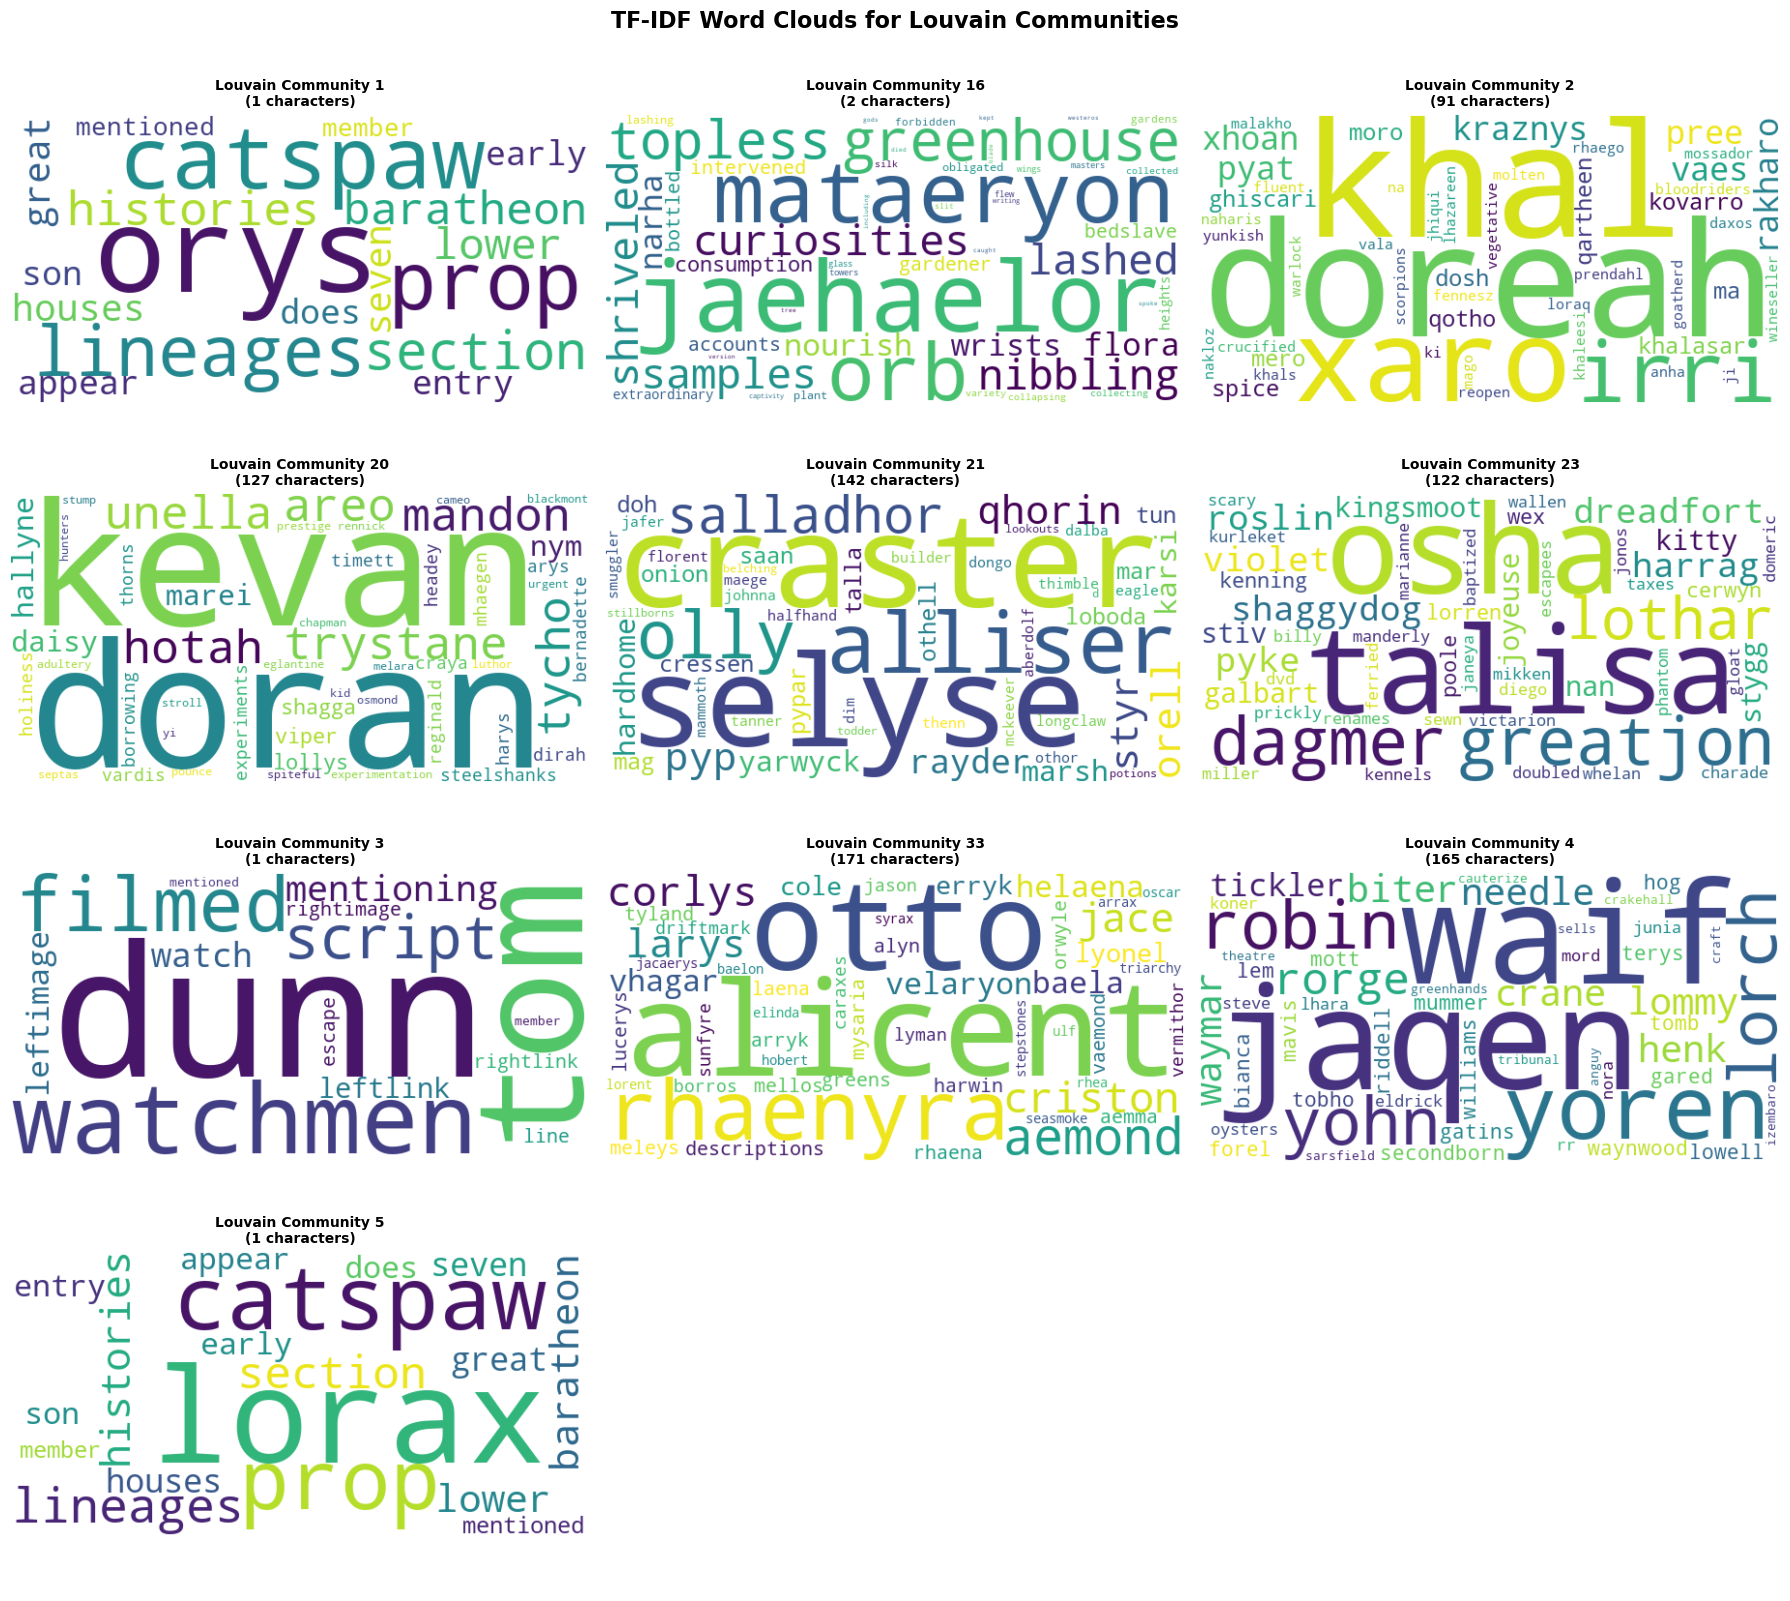

In [63]:
# TF-IDF Analysis for Louvain Communities with Word Clouds
from wordcloud import WordCloud
from collections import Counter
import math

print("\n=== TF-IDF for Louvain Communities ===\n")

# Load text for all characters in each community
louvain_community_texts = {}
louvain_char_lists = {}

# Use top communities by size
sorted_communities_with_idx = sorted(enumerate(dgw_communities), key=lambda x: len(x[1]), reverse=True)

for original_idx, comm in sorted_communities_with_idx[:10]:  # Top 10 communities
    comm_name = f"Louvain Community {original_idx+1}"
    chars_in_comm = sorted(list(comm))
    louvain_char_lists[comm_name] = chars_in_comm
    
    print(f"Loading text for {comm_name} ({len(chars_in_comm)} characters)...")
    
    # Load and combine text for all characters in this community
    comm_text = []
    for char in chars_in_comm:
        file_path = os.path.join(got_files_path, f"{char}.txt")
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                # Truncate after "==In the books==" section
                in_books_idx = text.find("==In the books==")
                if in_books_idx != -1:
                    text = text[:in_books_idx]
                comm_text.append(text.lower())
    
    louvain_community_texts[comm_name] = ' '.join(comm_text)

# Tokenize
print("\nTokenizing...")
louvain_token_list = {}
for comm_name, text in louvain_community_texts.items():
    tokens = [w for w in text.split() if w.isalpha() and w not in stop_words]
    louvain_token_list[comm_name] = tokens

# Calculate TF (raw counts)
louvain_tf_raw = {c: Counter(louvain_token_list[c]) for c in louvain_token_list}

# Calculate augmented TF
def to_augmented(counter):
    if not counter:
        return {}
    m = max(counter.values())
    return {w: 0.5 + 0.5 * (c / m) for w, c in counter.items()}

louvain_tf_aug = {c: to_augmented(cnt) for c, cnt in louvain_tf_raw.items()}

# Calculate IDF with base-10 logarithm
N_louvain = len(louvain_tf_aug)
all_words_louvain = set(w for c in louvain_tf_aug for w in louvain_tf_aug[c])
df_louvain = {w: sum(1 for c in louvain_tf_aug if w in louvain_tf_aug[c]) for w in all_words_louvain}
idf_louvain = {w: math.log10(N_louvain / df_louvain[w]) for w in df_louvain}

# Calculate TF-IDF
tfidf_louvain = {
    c: {w: louvain_tf_aug[c][w] * idf_louvain[w] for w in louvain_tf_aug[c] if w in idf_louvain}
    for c in louvain_tf_aug
}

print(f"Calculated TF-IDF for {len(tfidf_louvain)} Louvain communities")

# Create word clouds
print("\n=== Creating Word Clouds for Louvain Communities ===\n")

cols = 3
rows = math.ceil(len(tfidf_louvain) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for i, comm_name in enumerate(sorted(tfidf_louvain.keys())):
    ax = axes[i]
    scores = tfidf_louvain[comm_name]
    
    if not scores:
        ax.axis("off")
        continue
    
    # Normalize scores
    max_score = max(scores.values())
    normalized_scores = {w: v / max_score for w, v in scores.items()}
    
    # Create word cloud
    wc = WordCloud(width=600, height=300, background_color="white",
                   collocations=False, max_words=50).generate_from_frequencies(normalized_scores)
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{comm_name}\n({len(louvain_char_lists[comm_name])} characters)", 
                 fontsize=10, fontweight='bold')

# Turn off unused axes
for j in range(len(tfidf_louvain), len(axes)):
    axes[j].axis("off")

plt.suptitle('TF-IDF Word Clouds for Louvain Communities', fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

In [87]:
len(sorted_communities_with_idx)

34

In [86]:
for l in sorted_communities_with_idx:
    print(l)
    print(len(l[1]))

(32, {'Kelvyn', 'Lord Merryweather', 'Gerardys', 'Moondancer', 'Yorbert Royce', 'Addam', 'Cheese', 'Willis Fell', 'Silver Denys', 'Joffrey Velaryon', 'Chester Mooton', 'Sharako Lohar', 'Mellos', 'Simon Staunton', 'Rickon Stark (father of Cregan)', 'Raylon Bracken', 'Sunfyre', 'Mickon', 'Sylvi', 'Visenya Targaryen (daughter of Rhaenyra)', 'Serena Frey', 'Maris Baratheon', 'Gyles Belgrave', 'Jerard', 'Aegon Targaryen (son of Rhaenyra)', 'Allun Caswell', 'Vhagar', 'Lyman Beesbury', 'Alyn of Hull', 'Steffon Darklyn', 'Master of Revels (The Heirs of the Dragon)', 'Jaehaerys Targaryen (son of Aegon II)', "Gormon Massey's son", 'Jayne', 'Lorent Marbrand', 'Orwyle', 'Joffrey Lonmouth', 'Bartimos Celtigar', 'Meleys', 'Luthor Largent', 'Dreamfyre', 'Aemma Arryn', 'Eddard Waters', 'Tyland Lannister', 'Axell Bulwer', 'Helaena Targaryen', 'Rhaenyra Targaryen', 'Lady Mallister', 'Amos Bracken', 'Baela Targaryen', 'Mujja', 'Laenor Velaryon', 'High Septon (Viserys I)', 'Vermithor', 'Velaryon knight', 

In [73]:
sorted(tfidf_louvain.keys())

['Louvain Community 1',
 'Louvain Community 16',
 'Louvain Community 2',
 'Louvain Community 20',
 'Louvain Community 21',
 'Louvain Community 23',
 'Louvain Community 3',
 'Louvain Community 33',
 'Louvain Community 4',
 'Louvain Community 5']


=== TF-IDF for Louvain Communities (Unweighted Graph) ===

Loading text for Louvain Community 21 (187 characters)...
Loading text for Louvain Community 22 (170 characters)...
Loading text for Louvain Community 12 (144 characters)...
Loading text for Louvain Community 13 (129 characters)...
Loading text for Louvain Community 2 (90 characters)...
Loading text for Louvain Community 11 (75 characters)...
Loading text for Louvain Community 18 (15 characters)...
Loading text for Louvain Community 1 (12 characters)...
Loading text for Louvain Community 4 (11 characters)...
Loading text for Louvain Community 10 (2 characters)...

Tokenizing...
Loading text for Louvain Community 18 (15 characters)...
Loading text for Louvain Community 1 (12 characters)...
Loading text for Louvain Community 4 (11 characters)...
Loading text for Louvain Community 10 (2 characters)...

Tokenizing...
Calculated TF-IDF for 10 Louvain communities (unweighted)

=== Creating Word Clouds for Louvain Communities (Unweig

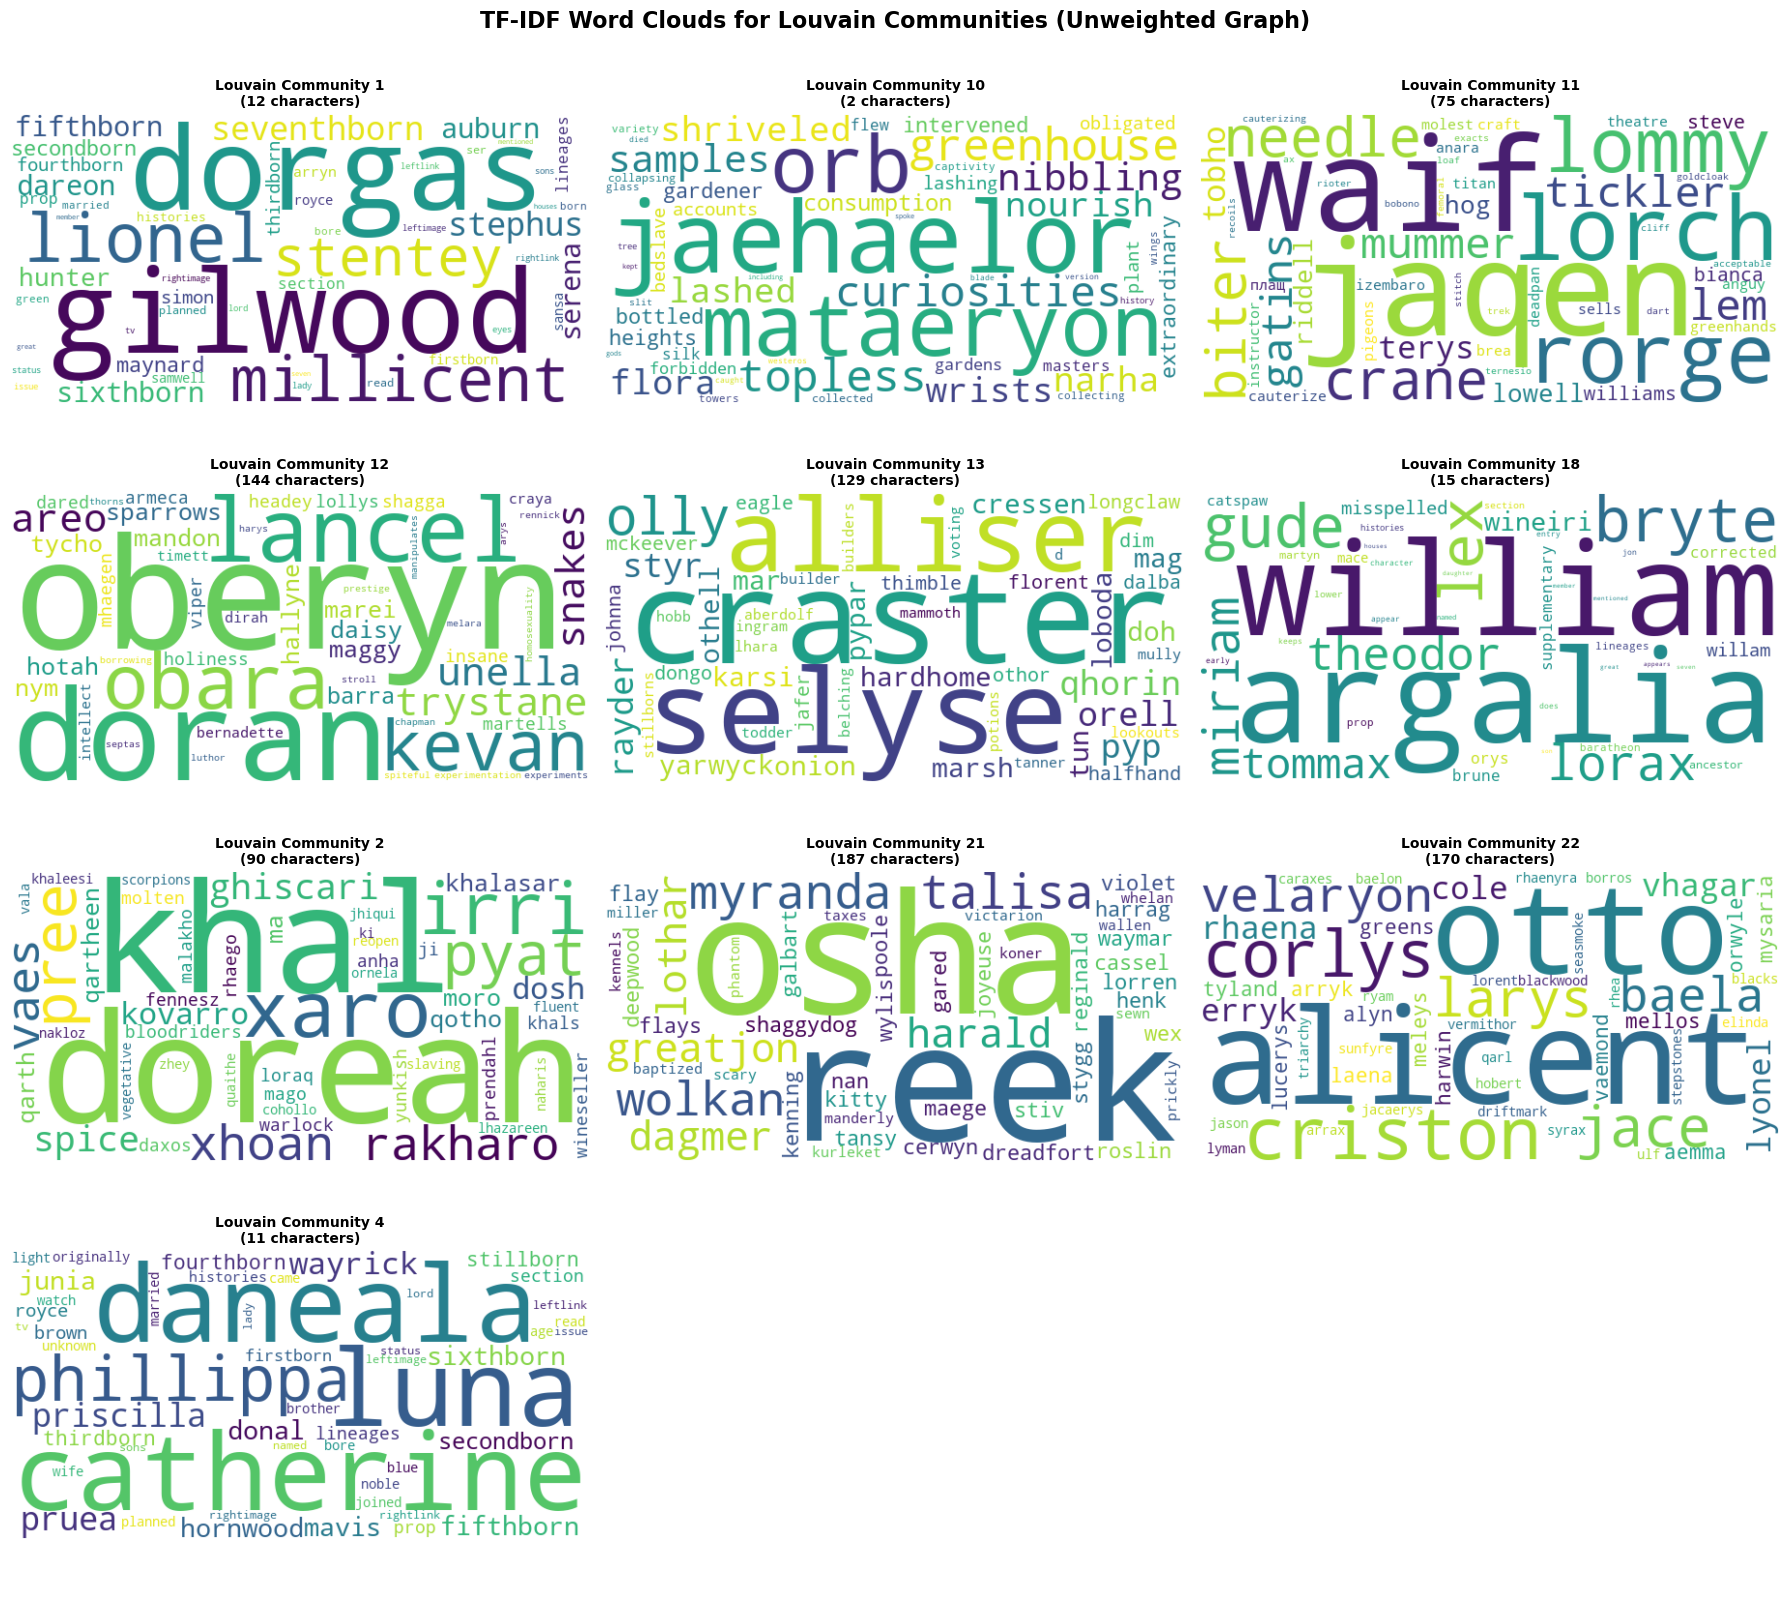

In [64]:
# TF-IDF Analysis for Louvain Communities (Unweighted) with Word Clouds
from wordcloud import WordCloud
from collections import Counter
import math

print("\n=== TF-IDF for Louvain Communities (Unweighted Graph) ===\n")

# Load text for all characters in each community
louvain_unw_community_texts = {}
louvain_unw_char_lists = {}

# Use top communities by size
sorted_communities_unw_with_idx = sorted(enumerate(dg_communities), key=lambda x: len(x[1]), reverse=True)

for original_idx, comm in sorted_communities_unw_with_idx[:10]:  # Top 10 communities
    comm_name = f"Louvain Community {original_idx+1}"
    chars_in_comm = sorted(list(comm))
    louvain_unw_char_lists[comm_name] = chars_in_comm
    
    print(f"Loading text for {comm_name} ({len(chars_in_comm)} characters)...")
    
    # Load and combine text for all characters in this community
    comm_text = []
    for char in chars_in_comm:
        file_path = os.path.join(got_files_path, f"{char}.txt")
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                # Truncate after "==In the books==" section
                in_books_idx = text.find("==In the books==")
                if in_books_idx != -1:
                    text = text[:in_books_idx]
                comm_text.append(text.lower())
    
    louvain_unw_community_texts[comm_name] = ' '.join(comm_text)

# Tokenize
print("\nTokenizing...")
louvain_unw_token_list = {}
for comm_name, text in louvain_unw_community_texts.items():
    tokens = [w for w in text.split() if w.isalpha() and w not in stop_words]
    louvain_unw_token_list[comm_name] = tokens

# Calculate TF (raw counts)
louvain_unw_tf_raw = {c: Counter(louvain_unw_token_list[c]) for c in louvain_unw_token_list}

# Calculate augmented TF
def to_augmented_unw(counter):
    if not counter:
        return {}
    m = max(counter.values())
    return {w: 0.5 + 0.5 * (c / m) for w, c in counter.items()}

louvain_unw_tf_aug = {c: to_augmented_unw(cnt) for c, cnt in louvain_unw_tf_raw.items()}

# Calculate IDF with base-10 logarithm
N_louvain_unw = len(louvain_unw_tf_aug)
all_words_louvain_unw = set(w for c in louvain_unw_tf_aug for w in louvain_unw_tf_aug[c])
df_louvain_unw = {w: sum(1 for c in louvain_unw_tf_aug if w in louvain_unw_tf_aug[c]) for w in all_words_louvain_unw}
idf_louvain_unw = {w: math.log10(N_louvain_unw / df_louvain_unw[w]) for w in df_louvain_unw}

# Calculate TF-IDF
tfidf_louvain_unw = {
    c: {w: louvain_unw_tf_aug[c][w] * idf_louvain_unw[w] for w in louvain_unw_tf_aug[c] if w in idf_louvain_unw}
    for c in louvain_unw_tf_aug
}

print(f"Calculated TF-IDF for {len(tfidf_louvain_unw)} Louvain communities (unweighted)")

# Create word clouds
print("\n=== Creating Word Clouds for Louvain Communities (Unweighted) ===\n")

cols = 3
rows = math.ceil(len(tfidf_louvain_unw) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for i, comm_name in enumerate(sorted(tfidf_louvain_unw.keys())):
    ax = axes[i]
    scores = tfidf_louvain_unw[comm_name]
    
    if not scores:
        ax.axis("off")
        continue
    
    # Normalize scores
    max_score = max(scores.values())
    normalized_scores = {w: v / max_score for w, v in scores.items()}
    
    # Create word cloud
    wc = WordCloud(width=600, height=300, background_color="white",
                   collocations=False, max_words=50).generate_from_frequencies(normalized_scores)
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"{comm_name}\n({len(louvain_unw_char_lists[comm_name])} characters)", 
                 fontsize=10, fontweight='bold')

# Turn off unused axes
for j in range(len(tfidf_louvain_unw), len(axes)):
    axes[j].axis("off")

plt.suptitle('TF-IDF Word Clouds for Louvain Communities (Unweighted Graph)', fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

=== Louvain Community 33 (Weighted) ===

Size: 171 characters

Members:
Addam, Addam of Hull, Adrian Redfort, Aegon II Targaryen, Aegon Targaryen (son of Rhaenyra), Aemma Arryn, Aemond Targaryen, Aeron Bracken, Alfred Broome, Alicent Hightower, Allun Caswell, Alyn of Hull, Alys Rivers, Alyssa Targaryen, Alyssa Velaryon, Amos Bracken, Arrax, Arryk Cargyll, Axell Bulwer, Baela Targaryen, Baelon Targaryen, Balerion, Bartimos Celtigar, Beric Dondarrion (son of Simon), Blood, Boremund Baratheon, Borros Baratheon, Brett Lannister, Caraxes, Cassandra Baratheon, Ceira Lannister, Cheese, Chester Mooton, Cley, Corlys Velaryon, Craghas Drahar, Cregan Stark, Criston Cole, Daemon Targaryen, Daeron Targaryen, Davos Blackwood, Desmond Caron, Dragonkeeper Acolyte (The Heirs of the Dragon), Dragonkeeper Elder (The Heirs of the Dragon), Dragonkeeper Elder (The Princess and the Queen), Dreamfyre, Dyana, Eddard Waters, Elinda Massey, Ellyn Baratheon, Erryk Cargyll, Eustace, Floris Baratheon, Forrest Frey,

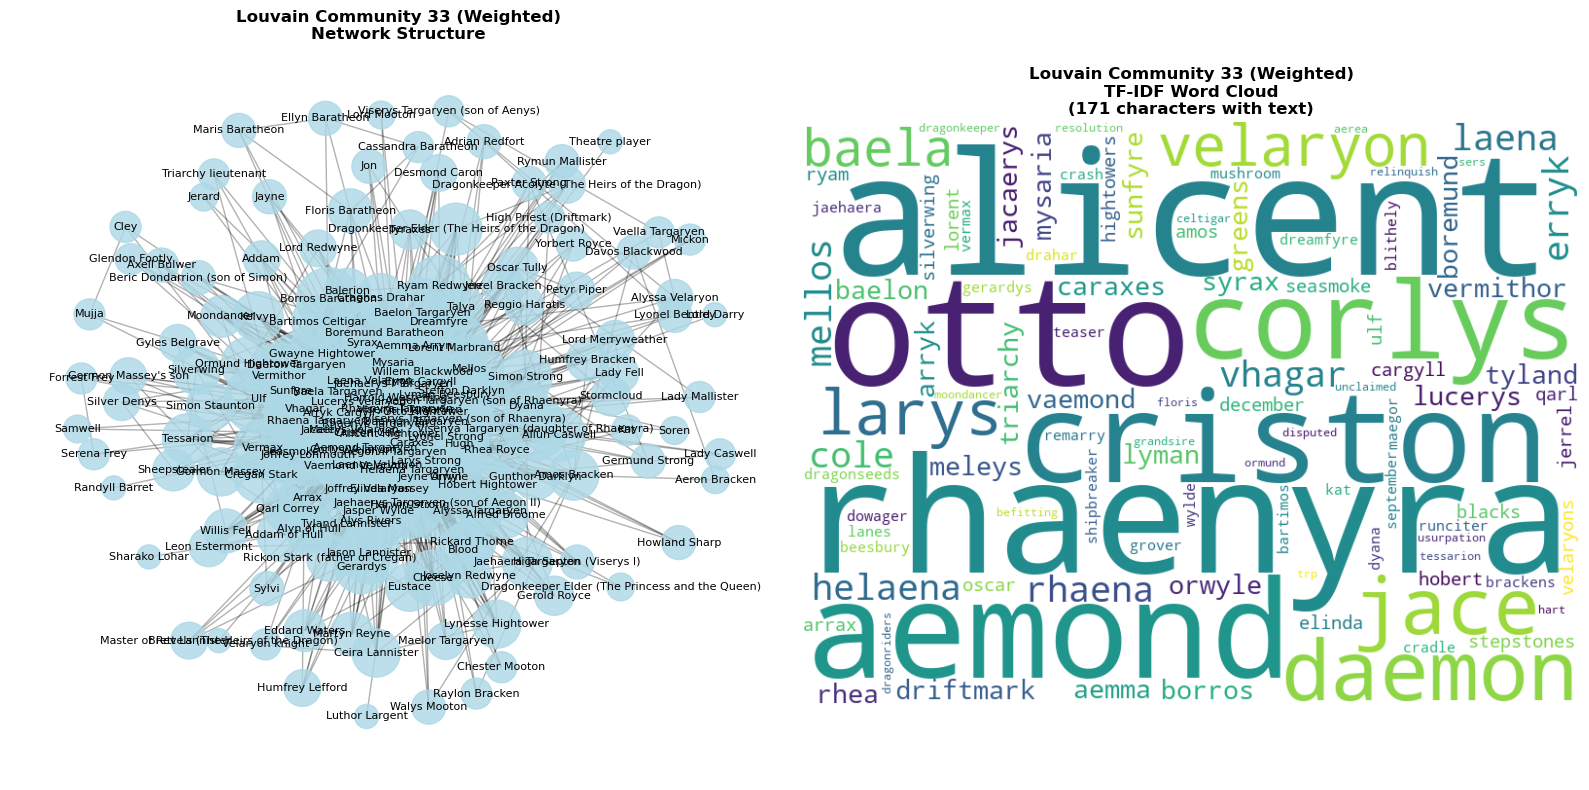

In [72]:
def display_community(community_idx, community_type='louvain', graph_type='weighted'):
    """
    Display detailed information about a specific community including:
    - Members list
    - Network visualization
    - TF-IDF word cloud (using pre-computed TF-IDF data)
    
    Parameters:
    -----------
    community_idx : int
        The 0-based index of the community (e.g., 0 for Community 1)
    community_type : str, default='louvain'
        Type of community detection: 'louvain' or 'kclique'
    graph_type : str, default='weighted'
        For Louvain only: 'weighted' or 'unweighted'
    """
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    import networkx as nx
    
    # Select the appropriate community list, TF-IDF data, and char lists
    if community_type.lower() == 'louvain':
        if graph_type.lower() == 'weighted':
            communities = dgw_communities
            graph = dgw_undir
            comm_name = f"Community {community_idx+1}"
            comm_label = f"Louvain Community {community_idx+1} (Weighted)"
            tfidf_data = tfidf
            char_lists = community_char_lists
        else:
            communities = dg_communities
            graph = dg_undir
            comm_name = f"Community {community_idx+1}"
            comm_label = f"Louvain Community {community_idx+1} (Unweighted)"
            # Use unweighted-specific variables if they exist
            tfidf_data = tfidf_louvain_unw if 'tfidf_louvain_unw' in globals() else None
            char_lists = louvain_unw_char_lists if 'louvain_unw_char_lists' in globals() else None
    elif community_type.lower() == 'kclique':
        if 'kclique_communities' not in globals():
            print("K-clique communities not available. Please run k-clique analysis first.")
            return
        communities = kclique_communities
        graph = dgw_undir  # k-clique uses weighted graph
        comm_name = f"K-Clique Community {community_idx+1}"
        comm_label = f"K-Clique Community {community_idx+1} (k={k_to_use})"
        tfidf_data = tfidf_kclique
        char_lists = kclique_char_lists
    else:
        print(f"Unknown community_type: {community_type}")
        return
    
    # Check if index is valid
    if community_idx < 0 or community_idx >= len(communities):
        print(f"Invalid community index: {community_idx}")
        print(f"Valid range: 0 to {len(communities)-1}")
        return
    
    # Get the community
    community = communities[community_idx]
    members = sorted(list(community))
    
    print(f"=== {comm_label} ===\n")
    print(f"Size: {len(members)} characters\n")
    print(f"Members:\n{', '.join(members)}\n")
    
    # Create subgraph
    subgraph = graph.subgraph(community)
    
    # Calculate and display network properties
    print(f"\n--- Network Properties ---")
    print(f"Nodes: {subgraph.number_of_nodes()}")
    print(f"Edges: {subgraph.number_of_edges()}")
    print(f"Density: {nx.density(subgraph):.3f}")
    
    try:
        avg_clustering = nx.average_clustering(subgraph)
        print(f"Avg Clustering: {avg_clustering:.3f}")
    except:
        print(f"Avg Clustering: N/A")
    
    # Create visualizations
    fig = plt.figure(figsize=(16, 8))
    
    # Subplot 1: Network visualization
    ax1 = plt.subplot(1, 2, 1)
    pos = nx.spring_layout(subgraph, k=1, iterations=50, seed=42)
    degrees = dict(subgraph.degree())
    node_sizes = [degrees[node] * 100 + 200 for node in subgraph.nodes()]
    
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3, ax=ax1)
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, 
                          node_color='lightblue', alpha=0.8, ax=ax1)
    nx.draw_networkx_labels(subgraph, pos, font_size=8, ax=ax1)
    
    ax1.set_title(f'{comm_label}\nNetwork Structure', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Subplot 2: Word cloud using pre-computed TF-IDF
    ax2 = plt.subplot(1, 2, 2)
    
    if tfidf_data is not None and comm_name in tfidf_data:
        scores = tfidf_data[comm_name]
        
        if scores:
            # Get character count from char_lists if available
            char_count = len(char_lists[comm_name]) if char_lists and comm_name in char_lists else len(members)
            
            # Normalize scores for word cloud
            max_score = max(scores.values())
            normalized_scores = {w: v / max_score for w, v in scores.items()}
            
            wc = WordCloud(width=800, height=600, background_color="white",
                           collocations=False, max_words=100).generate_from_frequencies(normalized_scores)
            
            ax2.imshow(wc, interpolation="bilinear")
            ax2.set_title(f'{comm_label}\nTF-IDF Word Cloud\n({char_count} characters with text)', 
                         fontsize=12, fontweight='bold')
            
            # Display top 20 TF-IDF words
            print(f"\n--- Top 20 TF-IDF Terms ---")
            top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:20]
            for i, (word, score) in enumerate(top_words, 1):
                print(f"{i:2d}. {word:20s} {score:.4f}")
        else:
            ax2.text(0.5, 0.5, 'No TF-IDF data available', 
                    ha='center', va='center', fontsize=14)
            ax2.set_title(f'{comm_label}\nNo TF-IDF Data', fontsize=12, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'TF-IDF data not pre-computed\nfor this community type', 
                ha='center', va='center', fontsize=14)
        ax2.set_title(f'{comm_label}\nNo TF-IDF Data', fontsize=12, fontweight='bold')
    
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
display_community(32, community_type='louvain')
# display_community(0, community_type='kclique')

In [70]:
sorted_communities_with_idx

[(32,
  {'Addam',
   'Addam of Hull',
   'Adrian Redfort',
   'Aegon II Targaryen',
   'Aegon Targaryen (son of Rhaenyra)',
   'Aemma Arryn',
   'Aemond Targaryen',
   'Aeron Bracken',
   'Alfred Broome',
   'Alicent Hightower',
   'Allun Caswell',
   'Alyn of Hull',
   'Alys Rivers',
   'Alyssa Targaryen',
   'Alyssa Velaryon',
   'Amos Bracken',
   'Arrax',
   'Arryk Cargyll',
   'Axell Bulwer',
   'Baela Targaryen',
   'Baelon Targaryen',
   'Balerion',
   'Bartimos Celtigar',
   'Beric Dondarrion (son of Simon)',
   'Blood',
   'Boremund Baratheon',
   'Borros Baratheon',
   'Brett Lannister',
   'Caraxes',
   'Cassandra Baratheon',
   'Ceira Lannister',
   'Cheese',
   'Chester Mooton',
   'Cley',
   'Corlys Velaryon',
   'Craghas Drahar',
   'Cregan Stark',
   'Criston Cole',
   'Daemon Targaryen',
   'Daeron Targaryen',
   'Davos Blackwood',
   'Desmond Caron',
   'Dragonkeeper Acolyte (The Heirs of the Dragon)',
   'Dragonkeeper Elder (The Heirs of the Dragon)',
   'Dragonkeepe

In [ ]:
dg_char['Jon Snow']

## Extract Houses and Titles from Communities

Analyze which noble houses and titles are represented in each community by parsing character wiki page metadata.

In [ ]:
import re

def extract_houses_and_titles(character_name, got_files_path='GoT_files'):
    """Extract houses and titles from a character's wiki page"""
    file_path = os.path.join(got_files_path, f"{character_name}.txt")
    houses = []
    titles = []
    
    if not os.path.exists(file_path):
        return houses, titles
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            
        # Extract House field
        house_match = re.search(r'\|\s*House\s*=\s*(.+?)(?:\n\||\n\})', text, re.IGNORECASE | re.DOTALL)
        if house_match:
            house_text = house_match.group(1)
            # Extract house names from [[House Name]] or [[House Name|Display]]
            house_names = re.findall(r'\[\[House ([^\]|]+)', house_text)
            houses.extend(house_names)
            # Also try without "House" prefix
            house_names_alt = re.findall(r'\[\[([^\]|]+?)\]\]', house_text)
            for name in house_names_alt:
                if not name.startswith('House ') and name not in houses:
                    houses.append(name)
        
        # Extract Affiliation field (alternative to House)
        affil_match = re.search(r'\|\s*Affiliation\s*=\s*(.+?)(?:\n\||\n\})', text, re.IGNORECASE | re.DOTALL)
        if affil_match:
            affil_text = affil_match.group(1)
            affil_names = re.findall(r'\[\[House ([^\]|]+)', affil_text)
            houses.extend(affil_names)
            affil_names_alt = re.findall(r'\[\[([^\]|]+?)\]\]', affil_text)
            for name in affil_names_alt:
                if not name.startswith('House ') and name not in houses and "Night's Watch" not in name:
                    houses.append(name)
        
        # Extract Titles field
        title_match = re.search(r'\|\s*Titles?\s*=\s*(.+?)(?:\n\||\n\})', text, re.IGNORECASE | re.DOTALL)
        if title_match:
            title_text = title_match.group(1)
            # Clean up the title text
            # Remove {{C|formerly}} and similar markers
            title_text = re.sub(r'\{\{[^}]+\}\}', '', title_text)
            # Remove {{Ref|...}} references
            title_text = re.sub(r'\{\{Ref\|[^}]+\}\}', '', title_text)
            # Split by <br> or newlines
            title_lines = re.split(r'<br>|<br/>|\n', title_text)
            for line in title_lines:
                # Extract titles from [[Title]] or plain text
                title_matches = re.findall(r'\[\[([^\]|]+)', line)
                if title_matches:
                    titles.extend(title_matches)
                else:
                    # Clean and add non-empty lines
                    clean_line = line.strip()
                    if clean_line and not clean_line.startswith('|'):
                        titles.append(clean_line)
        
        # Remove duplicates while preserving order
        houses = list(dict.fromkeys(houses))
        titles = list(dict.fromkeys(titles))
        
        # Clean up titles - remove empty strings and very short ones
        titles = [t for t in titles if len(t.strip()) > 2]
        
    except Exception as e:
        pass
    
    return houses, titles

# Test on a known character
test_houses, test_titles = extract_houses_and_titles("Jon Snow")
print("Test extraction for Jon Snow:")
print(f"Houses: {test_houses}")
print(f"Titles: {test_titles[:5] if len(test_titles) > 5 else test_titles}")

In [ ]:
# Extract houses and titles for Louvain communities
print("=== Houses and Titles by Community (Louvain) ===\n")

community_houses = {}
community_titles = {}

for i, comm in enumerate(dgw_communities):
    all_houses = []
    all_titles = []
    
    for char in comm:
        houses, titles = extract_houses_and_titles(char)
        all_houses.extend(houses)
        all_titles.extend(titles)
    
    # Get unique houses and titles
    unique_houses = list(dict.fromkeys(all_houses))
    unique_titles = list(dict.fromkeys(all_titles))
    
    community_houses[f"Community {i+1}"] = unique_houses
    community_titles[f"Community {i+1}"] = unique_titles

# Display results for top 10 communities (by size)
sorted_communities_idx = sorted(range(len(dgw_communities)), key=lambda x: len(dgw_communities[x]), reverse=True)

for rank, idx in enumerate(sorted_communities_idx[:10], 1):
    comm_name = f"Community {idx+1}"
    size = len(dgw_communities[idx])
    houses = community_houses[comm_name]
    titles = community_titles[comm_name]
    
    print(f"\n{comm_name} ({size} members):")
    print(f"  Houses ({len(houses)}): {', '.join(houses[:10])}{' ...' if len(houses) > 10 else ''}")
    print(f"  Titles ({len(titles)}): {', '.join(titles[:10])}{' ...' if len(titles) > 10 else ''}")

In [ ]:
# Extract houses and titles for K-Clique communities
if k_to_use:
    print("\n=== Houses and Titles by K-Clique Community ===\n")
    
    kclique_community_houses = {}
    kclique_community_titles = {}
    
    for i, comm in enumerate(kclique_communities):
        all_houses = []
        all_titles = []
        
        for char in comm:
            houses, titles = extract_houses_and_titles(char)
            all_houses.extend(houses)
            all_titles.extend(titles)
        
        # Get unique houses and titles
        unique_houses = list(dict.fromkeys(all_houses))
        unique_titles = list(dict.fromkeys(all_titles))
        
        kclique_community_houses[f"K-Clique Community {i+1}"] = unique_houses
        kclique_community_titles[f"K-Clique Community {i+1}"] = unique_titles
    
    # Display results for top 10 k-clique communities (by size)
    sorted_kclique_idx = sorted(range(len(kclique_communities)), key=lambda x: len(kclique_communities[x]), reverse=True)
    
    for rank, idx in enumerate(sorted_kclique_idx[:10], 1):
        comm_name = f"K-Clique Community {idx+1}"
        size = len(kclique_communities[idx])
        houses = kclique_community_houses[comm_name]
        titles = kclique_community_titles[comm_name]
        
        print(f"\n{comm_name} ({size} members):")
        print(f"  Houses ({len(houses)}): {', '.join(houses[:10])}{' ...' if len(houses) > 10 else ''}")
        print(f"  Titles ({len(titles)}): {', '.join(titles[:10])}{' ...' if len(titles) > 10 else ''}")
else:
    print("No k-clique communities available for house/title extraction.")

## Analyzing Smaller K-Clique Communities

Focus on smaller, more tightly-knit k-clique communities by filtering by size.

NOT WHAT I WANT, REDO 

In [ ]:
# Filter and analyze smaller k-clique communities
# k = size of clique (each node must be connected to k-1 other nodes in the clique)
k = k_to_use

if k:
    print(f"=== Smaller K-Clique Communities (k={k}) ===\n")
    print(f"k = {k} means each node must be connected to at least {k-1} other nodes in the clique\n")
    
    # Sort communities by size (smallest to largest)
    small_communities_sorted = sorted(enumerate(kclique_communities), key=lambda x: len(x[1]))
    
    print(f"Total k-clique communities: {len(kclique_communities)}\n")
    
    # Display all communities sorted by size
    for rank, (idx, comm) in enumerate(small_communities_sorted, 1):
        comm_name = f"K-Clique Community {idx+1}"
        size = len(comm)
        members = sorted(list(comm))
        
        print(f"\n{rank}. {comm_name} ({size} members):")
        print(f"   {', '.join(members)}")
else:
    print("No k-clique communities available.")